In [1]:
import pandas as pd
import numpy as np
import re
import string
import unicodedata
import plotly_express as px
import plotly.io as pio
from sklearn import preprocessing
import pandas_profiling
import datetime
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt 
from sklearn import preprocessing
import warnings
import math
import plotly.express as px
import statsmodels
import scipy
import sklearn
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


import math


warnings.filterwarnings("ignore")

# scipy
print('scipy: %s' % scipy.__version__)
# numpy
print('numpy: %s' % np.__version__)
# matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
print('pandas: %s' % pd.__version__)
# scikit-learn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
print('statsmodels: %s' % statsmodels.__version__)
#print('unicodedata: %s' % unicodedata.__version__)

scipy: 1.4.1
numpy: 1.18.2
matplotlib: 3.2.1
pandas: 1.0.3
sklearn: 0.22.2.post1
statsmodels: 0.11.1


In [2]:
#verificar feriados 
def isHoliday(dia,mes):
    if dia == 1:
        if mes == 1 or mes ==5:
            return(True)
    if (dia ==2 or dia==15) and mes==11:
        return(True)
    if (dia ==7 or dia==20) and mes == 9:
        return(True)
    if mes == 4 and dia==21:
        return(True)    
    if mes==10 and (dia==12):
        return(True)
    if mes==12 and (dia ==25 or dia ==24):
        return(True)
    if mes==12 and dia==31:
        return(True)
    return(False)   

def AdjustFeriado(x):
    #print(x)
    if x['Feriado'] == 0 or x['Feriado'] == 1:
        return(x['Feriado'])
       # print('else')
       # print(x['Feriado'] >=0)
    else:
        dia = x['judgmentDate'].day
        mes = x['judgmentDate'].month 
        feriado = 0 if isHoliday(dia,mes) == True else 1
        return(feriado)
    
def AdjustWeekDay(x):    
    if x['weekDay'] > 0:
        return(x['weekDay'])
    else:
        return(x['judgmentDate'].weekday())        
    
def AdjustWeekType(x):    
    if x['weekType'] > 0:
        return(x['weekType'])
    else:
        weekType = 1 if x['judgmentDate'].weekday() <5 else 0
        return(weekType)     

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_teste(series,title='',prints=False):    
    summay = ''
    if prints:
        print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC',) 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():        
        out[f'critical value ({key})']=val
        
    if prints:
        display(pd.DataFrame(out))
    
    
    
    if result[1] <= 0.05:
        summary = "Strong evidence against the null hypothesis \n Reject the null hypothesis \n Data has no unit root and is stationary"
        if prints:
            print("Strong evidence against the null hypothesis")
            print("Reject the null hypothesis")
            print("Data has no unit root and is stationary")        
    else:
        summary = "Weak evidence against the null hypothesis \n Fail to reject the null hypothesis \n Data has a unit root and is non-stationary"
        if prints:
            print("Weak evidence against the null hypothesis")
            print("Fail to reject the null hypothesis")
            print("Data has a unit root and is non-stationary")
            
    
    return(result[1],title,result[0],result[2],result[3],result[4],result[5],summary) 

In [4]:
#carrega
df_count_day_type = pd.read_csv('./data_joao/df_count_day_type_modificado.csv',sep=",")#,parse_dates=['judgmentDate'])
df_count_week_day_type = pd.read_csv('./data_joao/df_count_week_day_type_modificado.csv',sep=",")
df_count_year_month_type = pd.read_csv('./data_joao/df_count_year_month_type_modificado.csv',sep=",")

dfUniqueTypes = df_count_day_type['type'].unique()

#cria indice
df_count_day_type.index = pd.to_datetime(df_count_day_type['judgmentDate'])
df_count_year_month_type.index = pd.to_datetime(df_count_year_month_type['yearMonth'])

#deleta colunas que sobraram da importacao e da criacao do indice
del df_count_day_type['Unnamed: 0']
del df_count_week_day_type['Unnamed: 0']
del df_count_year_month_type['Unnamed: 0']
del df_count_day_type['judgmentDate']
del df_count_year_month_type['yearMonth']

#calcula o total do dia
df_count_day_type['total'] = df_count_day_type.groupby(['judgmentDate'])['count'].agg('sum')
#salva as informacoes que nao serao pivotadas
ref = df_count_day_type[['weekDay','weekType','Feriado','total']]
#realiza o pivot
df_count_day_typeGRP = df_count_day_type.pivot(columns='type', values='count').fillna(0)

#transforma tudo pra int (count)
for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)
        
#faz o merge com as que foram salvas antes do pivot        
df_count_day_typeGRP = pd.merge(df_count_day_typeGRP,ref,on='judgmentDate',how='left')
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate').drop_duplicates()

#remove duplicadas e nulas pra fazer a frequencia diaria
df_count_day_typeGRP = df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP = df_count_day_typeGRP.drop_duplicates()
df_count_day_typeGRP = df_count_day_typeGRP.dropna()


df_count_day_typeGRP.sort_values(by='judgmentDate')
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP['Feriado'].apply( lambda x: 0 if x==True else 1)
df_count_day_typeGRP['weekType'] = pd.get_dummies(df_count_day_typeGRP['weekType'])
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D') #precisa pois abaixo seto os que faltam

#reseta o indice agora com todos os dias inclusive vazios e seta as informaçoes das datas novas (sem dados)
df_count_day_typeGRP = df_count_day_typeGRP.reset_index()    
df_count_day_typeGRP['Feriado'] = df_count_day_typeGRP.apply(AdjustFeriado,axis=1)
df_count_day_typeGRP['weekDay'] = df_count_day_typeGRP.apply(AdjustWeekDay,axis=1)
df_count_day_typeGRP['weekType'] = df_count_day_typeGRP.apply(AdjustWeekType,axis=1)

#volta ao estado normal (com indice e frequencia)
df_count_day_typeGRP.index = df_count_day_typeGRP['judgmentDate']
del df_count_day_typeGRP['judgmentDate']
df_count_day_typeGRP = df_count_day_typeGRP.asfreq('D')

#seta para zerado as datas que nao existiam antes 
df_count_day_typeGRP = df_count_day_typeGRP.fillna(0)

for i in df_count_day_typeGRP.columns:    
        df_count_day_typeGRP[i] = df_count_day_typeGRP[i].astype(int)


In [5]:
df_count_day_typeGRP.head(3)
df = df_count_day_typeGRP
dfMonth = df.resample('MS').sum()
dfQuarter = df.resample('QS').sum()
dfYear = df.resample('Y').sum()

field = 'total'

In [6]:
display(dfYear.head(3))
display(df.head(3))

Agravo  Agravo Embargos Infringentes  Agravo Inominado  \
judgmentDate                                                           
2000-12-31       607                             0                 4   
2001-12-31      1649                             0                 0   
2002-12-31      2670                             0                 1   

              Agravo Interno  Agravo Lei  Agravo Regimental  \
judgmentDate                                                  
2000-12-31               218           3                208   
2001-12-31               576           8                259   
2002-12-31               737           7                445   

              Agravo de Instrumento  \
judgmentDate                          
2000-12-31                     5141   
2001-12-31                     7443   
2002-12-31                    10726   

              Agravo de Instrumento em Recurso Extraordinario  \
judgmentDate                                                    
2000-12-31                                                  0   
2001-12-31                                                  0   
2002-12-31                                                  0   

              Agravo de Petição  Agravo em Execução  ...  \
judgmentDate                                         ...   
2000-12-31                    0                   5  ...   
2001-12-31                    0                  19  ...   
2002-12-31                    0                  44  ...   

              Suspenção de Liminar ou Antecipação de Tutela  \
judgmentDate                                                  
2000-12-31                                                0   
2001-12-31                                                0   
2002-12-31                                                0   

              Termo Circunstanciado  Tutela Antecipada Antecedente  \
judgmentDate                                                         
2000-12-31                        0                              0   
2001-12-31                        1                              0   
2002-12-31                        0                              0   

              Tutela Cautelar Antecedente  Tutela Provisoria  \
judgmentDate                                                   
2000-12-31                              0                  0   
2001-12-31                              0                  0   
2002-12-31                              0                  0   

              Uniformização de Jurisprudência  weekDay  weekType  Feriado  \
judgmentDate                                                                
2000-12-31                                  0     1092       260      354   
2001-12-31                                  0     1092       261      354   
2002-12-31                                  2     1093       261      354   

              total  
judgmentDate         
2000-12-31    27076  
2001-12-31    49109  
2002-12-31    67173  

[3 rows x 123 columns]

Agravo  Agravo Embargos Infringentes  Agravo Inominado  \
judgmentDate                                                           
2000-01-03         0                             0                 0   
2000-01-04         0                             0                 0   
2000-01-05         0                             0                 0   

              Agravo Interno  Agravo Lei  Agravo Regimental  \
judgmentDate                                                  
2000-01-03                 0           0                  0   
2000-01-04                 0           0                  0   
2000-01-05                 0           0                  0   

              Agravo de Instrumento  \
judgmentDate                          
2000-01-03                        2   
2000-01-04                        0   
2000-01-05                        0   

              Agravo de Instrumento em Recurso Extraordinario  \
judgmentDate                                                    
2000-01-03                                                  0   
2000-01-04                                                  0   
2000-01-05                                                  0   

              Agravo de Petição  Agravo em Execução  ...  \
judgmentDate                                         ...   
2000-01-03                    0                   0  ...   
2000-01-04                    0                   0  ...   
2000-01-05                    0                   0  ...   

              Suspenção de Liminar ou Antecipação de Tutela  \
judgmentDate                                                  
2000-01-03                                                0   
2000-01-04                                                0   
2000-01-05                                                0   

              Termo Circunstanciado  Tutela Antecipada Antecedente  \
judgmentDate                                                         
2000-01-03                        0                              0   
2000-01-04                        0                              0   
2000-01-05                        0                              0   

              Tutela Cautelar Antecedente  Tutela Provisoria  \
judgmentDate                                                   
2000-01-03                              0                  0   
2000-01-04                              0                  0   
2000-01-05                              0                  0   

              Uniformização de Jurisprudência  weekDay  weekType  Feriado  \
judgmentDate                                                                
2000-01-03                                  0        0         1        1   
2000-01-04                                  0        1         1        1   
2000-01-05                                  0        2         1        1   

              total  
judgmentDate         
2000-01-03        2  
2000-01-04        0  
2000-01-05        0  

[3 rows x 123 columns]

In [7]:
def MakePredictionsTestAndForecast(modelType,dfParam,
                                   field,testPercentSize,
                                   start_p=2,start_q=2,max_p=5,max_q=5,max_d=2,d=None,seasonal=False,seasonalM=7,
                                   futureEstimation=30,exogField='',
                                   holtAlpha=12, holtTrend='add',figsizeX=30,figsizeY=15):

    figsize=(figsizeX,figsizeY)
  #  
    dfInt = dfParam.copy()
  #  
    if adf_teste(dfParam[field],'',False)[0] >0.05:
        dfInt[field] = diff(dfInt[field],k_diff=1)
        print('Série não estacionaria, aplicado Fuller!')
        dfInt = dfInt.dropna()        
    else:
        dfInt = dfInt
       
    #display(dfInt.head(3))
        
        
    test_size = (len(dfInt) - int((testPercentSize * len(dfInt))/100))
    train = dfInt.iloc[:test_size]
    test = dfInt.iloc[test_size:]    
    #print('ADF Test:',adf_test(dfInt[field]))       
    #print('ADF Test:',adf_test(dfInt[field]))
    
    print("Tamanho do treino: ", str(len(train)))
    print("Tamanho do teste: ", str(len(test)))
    print('test Size:',test_size)
    start=len(train)
    end=len(train)+len(test)-1
    
    title = ''#Real Manufacturing and Trade Inventories'
    ylabel=''
    xlabel='' # we don't really need a label here
    
    if modelType == 'SMOOTHING':
        alpha = 2/(holtAlpha+1)
        alphaStr = str(alpha)
        dfSmooth = dfInt
        dfSmooth = dfSmooth[[field]]
        dfSmooth['SimSmooth_'+alphaStr] = SimpleExpSmoothing(df[field]).fit(smoothing_level=holtAlpha, optimized=False).fittedvalues.shift(-1)
        dfSmooth['ExpSmooth_'+alphaStr] = ExponentialSmoothing(df[field],trend=holtTrend).fit().fittedvalues.shift(-1)
        dfSmooth['SeasonalExpSmooth_'+alphaStr] = ExponentialSmoothing(dfSmooth[field],trend=holtTrend,seasonal=holtTrend,seasonal_periods=seasonalM).fit().fittedvalues
        #dfSmooth = dfSmooth.apply(lambda x: np.sqrt(x.dot(x)), axis=1)
        ax = dfInt[field].plot(legend=True,figsize=figsize,title=title)
        dfSmooth['ExpSmooth_'+alphaStr].plot(legend=True,linestyle='dashed')
        dfSmooth['SeasonalExpSmooth_'+alphaStr].plot(legend=True,linestyle='dashed')
        #df.replace([np.inf, -np.inf], np.nan)

        ax.autoscale(axis='x',tight=True)        
        #isplay(dfSmooth)
        return
    
    
    if seasonal == True:
        autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,seasonal=seasonal,m=seasonalM,trace=False)
    else:
        autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,trace=False)
        
    print(f'ORDER: {autoArimaResults.order}')
    print(f'SEASONAL ORDER: {autoArimaResults.seasonal_order}')
        
    if modelType == 'ARIMA':        
        model = ARIMA(train[field],order=autoArimaResults.order)
    if modelType == 'SARIMA':
        model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
    if modelType == 'SARIMAX':
        model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)                
    results = model.fit()
    results.summary()
    
    print('Executando ' + modelType + ' Param order: '+ str(autoArimaResults.order))
    
    if modelType == 'ARIMA':
        predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order} Predictions')
    if modelType == 'SARIMA':
        predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
    if modelType == 'SARIMAX':
        exog_forecast = test[exogField]
        predictions = results.predict(start=start, end=end, exog=exog_forecast, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
        
    ax = test[field].rename('test '+field).plot(legend=True,figsize=figsize,title=title)
    predictions.plot(legend=True)
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if modelType == 'SARIMAX':
        print('incluindo feriados')
        for x in test.query('Feriado==0').index: 
            ax.axvline(x=x, color='k', alpha = 0.3);
    
    error = mean_squared_error(test[field], predictions)
    print(f'{modelType}{autoArimaResults.order} MSE Error: {error:11.10}')
    error = rmse(test[field], predictions)
    print(f'{modelType}{autoArimaResults.order} RMSE Error: {error:11.10}')
    
    for i in range(len(predictions)):
        print(f"predicted={predictions[i]:<11.10}, expected={test[field][i]}")
  
    
    #FORECAST
    if modelType == 'ARIMA':
        model = ARIMA(dfInt[field],order=autoArimaResults.order)
    if modelType == 'SARIMA':
        model = SARIMAX(dfInt[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
    if modelType == 'SARIMAX':
        model = SARIMAX(dfInt[field],exog=dfInt[exogField],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
    print(model.fit())
    results = model.fit()
    
    if modelType == 'ARIMA':
        fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order} Forecast')        
    if modelType == 'SARIMA':
        fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
    if modelType == 'SARIMAX':        
        exog_forecast = dfInt[:futureEstimation+1][exogField]
        print(len(dfInt))
        #display(exog_forecast)
        fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,exog=exog_forecast,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
    
    
    if modelType in ['SARIMA','SARIMAX','ARIMA']:        
        ax = dfInt[field].plot(legend=True,figsize=figsize,title=title)
        fcast.plot(legend=True,linestyle='dashed')
        ax.autoscale(axis='x',tight=True)
        ax.set(xlabel=xlabel, ylabel=ylabel)
        
        expected = test[field].values
        predictions = predictions.values
        forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
        bias = sum(forecast_errors) * 1.0/len(expected)
        print('Bias: %f' % bias)
    
    
    #n = len(dfInt)
    #i = math.ceil(train*n)
    #xTrain = np.arange(1,i)
    #xTest = np.arange((i+1),n)
    
    

In [8]:
def MakePredictionsTestPerformance(dfParam,
                                   field,testPercentSize,
                                   start_p=2,start_q=2,max_p=5,max_q=5,max_d=2,d=None,seasonal=False,seasonalM=7,
                                   futureEstimation=30,exogField=''):
    resultTestPerform = []
    
    for modelo in ['ARIMA','SARIMA','SARIMAX']:
        try:
            
            modelType = modelo
            
        
            dfInt = dfParam.copy()
            
            #if adf_teste(dfParam[field],'',False)[0] >0.05:
            #    dfInt[field] = diff(dfInt[field],k_diff=1)
            #    serieEstacionaria = 'Não'
            #    dfInt = dfInt.dropna()        
            #else:
            #    dfInt = dfInt
            #    serieEstacionaria = 'Sim'
    
            test_size = (len(dfInt) - int((testPercentSize * len(dfInt))/100))
            train = dfInt.iloc[:test_size]
            test = dfInt.iloc[test_size:]        
                        
            #print("Tamanho do treino: ", str(len(train)))
            #print("Tamanho do teste: ", str(len(test)))
            #print('test Size:',test_size)
            start=len(train)
            end=len(train)+len(test)-1
            
            title = ''
            ylabel=''
            xlabel='' 
           
            #display(dfInt)
           
            if seasonal == True:
                autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,seasonal=seasonal,m=seasonalM,trace=False)
            else:
                autoArimaResults = auto_arima(dfInt[field],start_p=0,start_q=0,max_q=max_q,max_p=max_p,d=d,max_d=max_d,trace=False)
                
            
                
            if modelType == 'ARIMA':        
                model = ARIMA(train[field],order=autoArimaResults.order)
            if modelType == 'SARIMA':
                model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
            if modelType == 'SARIMAX':
                model = SARIMAX(train[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)                
            results = model.fit()
            
            #print('Executando ' + modelType + ' Param order: '+ str(autoArimaResults.order))
            
            if modelType == 'ARIMA':
                predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order} Predictions')
            if modelType == 'SARIMA':
                predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
            if modelType == 'SARIMAX':
                exog_forecast = test[exogField]
                predictions = results.predict(start=start, end=end, exog=exog_forecast, typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order} Predictions')
                
            errorMean = mean_squared_error(test[field], predictions)
            #print(f'{modelType}{autoArimaResults.order} MSE Error: {errorMean:11.10}')
            errorRmse = rmse(test[field], predictions)
            #print(f'{modelType}{autoArimaResults.order} RMSE Error: {errorRmse:11.10}')       
          
            #FORECAST
            if modelType == 'ARIMA':
                model = ARIMA(dfInt[field],order=autoArimaResults.order)
            if modelType == 'SARIMA':
                model = SARIMAX(dfInt[field],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order)
            if modelType == 'SARIMAX':
                model = SARIMAX(dfInt[field],exog=dfInt[exogField],order=autoArimaResults.order,seasonal_order=autoArimaResults.seasonal_order,enforce_invertibility=False,enforce_stationarity=False)
            #print(model.fit())
            results = model.fit()
            
            if modelType == 'ARIMA':
                fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order} Forecast')        
            if modelType == 'SARIMA':
                fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
            if modelType == 'SARIMAX':        
                exog_forecast = dfInt[:futureEstimation+1][exogField]
                #print(len(dfInt))
                #display(exog_forecast)
                fcast = results.predict(len(dfInt),len(dfInt)+futureEstimation,exog=exog_forecast,typ='levels').rename(f'{modelType}{autoArimaResults.order}{autoArimaResults.seasonal_order}  Forecast')
            
            expected = test[field].values
            predictions = predictions.values
            forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
            bias = sum(forecast_errors) * 1.0/len(expected)                
            
            meanAbsolError = mean_absolute_error(expected, predictions)
    
            
            resultTestPerform.append({'Modelo':modelType,
                                      'Serie':field,
                                      'Estacionária':serieEstacionaria,
                                      'Ordem':autoArimaResults.order,
                                      'Ordem Sazonal': autoArimaResults.seasonal_order,
                                      'Média de valores do modelo':dfInt[field].mean(),
                                      'MeanSquaredError':errorMean,
                                      'RootMeanSquaredError':errorRmse,
                                      'MeanAbsoluteError':meanAbsolError,                                  
                                      'Bias':bias
                                     })
        except:
               print(f'Erro em {field}')
            #print(f'{modelType} verificado!')
        #display(pd.DataFrame(resultTestPerform))
    return(resultTestPerform)

In [9]:
MakePredictionsTestPerformance(dfMonth['2014-01-11':],'Apelação Rec',testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,
                               exogField='weekType')

Erro em Apelação Rec
Erro em Apelação Rec
Erro em Apelação Rec


[]

In [10]:
resultados= []
for i in dfUniqueTypes[0:]:
    print(i)   
    resultados.append(MakePredictionsTestPerformance(dfMonth['2014-01-11':],i,testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,
                               exogField=['weekDay','Feriado','weekType']))

Agravo de Instrumento
Erro em Agravo de Instrumento
Erro em Agravo de Instrumento
Erro em Agravo de Instrumento
Apelação Cível
Erro em Apelação Cível
Erro em Apelação Cível
Erro em Apelação Cível
Apelação e Reexame Necessário
Erro em Apelação e Reexame Necessário
Erro em Apelação e Reexame Necessário
Erro em Apelação e Reexame Necessário
Agravo
Erro em Agravo
Erro em Agravo
Erro em Agravo
Reexame Necessário
Erro em Reexame Necessário
Erro em Reexame Necessário
Erro em Reexame Necessário
Agravo Regimental
Erro em Agravo Regimental
Erro em Agravo Regimental
Erro em Agravo Regimental
Embargos de Declaração
Erro em Embargos de Declaração
Erro em Embargos de Declaração
Erro em Embargos de Declaração
Apelação Crime
Erro em Apelação Crime
Erro em Apelação Crime
Erro em Apelação Crime
Ação Rescisória
Erro em Ação Rescisória
Erro em Ação Rescisória
Erro em Ação Rescisória
Conflito de Competência
Erro em Conflito de Competência
Erro em Conflito de Competência
Erro em Conflito de Competência
Agra

Erro em Suspenção de Liminar ou Antecipação de Tutela
Erro em Suspenção de Liminar ou Antecipação de Tutela
Erro em Suspenção de Liminar ou Antecipação de Tutela
Petição
Erro em Petição
Erro em Petição
Erro em Petição
Intervenção em Município
Erro em Intervenção em Município
Erro em Intervenção em Município
Erro em Intervenção em Município
Crimes Ambientais
Erro em Crimes Ambientais
Erro em Crimes Ambientais
Erro em Crimes Ambientais
Embargos Infringentes e de Nulidade
Erro em Embargos Infringentes e de Nulidade
Erro em Embargos Infringentes e de Nulidade
Erro em Embargos Infringentes e de Nulidade
Exceção de Impedimento
Erro em Exceção de Impedimento
Erro em Exceção de Impedimento
Erro em Exceção de Impedimento
Intervenção no Estado
Erro em Intervenção no Estado
Erro em Intervenção no Estado
Erro em Intervenção no Estado
Procedimento Investigatório do MP
Erro em Procedimento Investigatório do MP
Erro em Procedimento Investigatório do MP
Erro em Procedimento Investigatório do MP
Ação P

In [11]:
display(pd.DataFrame(resultados))
ress = [] 
for i in resultados:
    if len(i)>=1:
        ress.append(i[0])
        if len(i)>=2:
            ress.append(i[1])
            if len(i)>=3:
                ress.append(i[2])
    
#display(pd.DataFrame(ress))

    
SarimasResults = pd.DataFrame(ress) #.plot.scatter(x='MeanSquaredError',y='Serie'

display(SarimasResults.sort_values(by ='RootMeanSquaredError',ascending=False))

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[119 rows x 0 columns]

KeyError: 'RootMeanSquaredError'

In [12]:
scatter_plot_top20_year = px.scatter(SarimasResults, x="RootMeanSquaredError", y="MeanSquaredError",color='Serie')
pio.show(scatter_plot_top20_year)


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of [] but received: RootMeanSquaredError

Série não estacionaria, aplicado Fuller!
Tamanho do treino:  49
Tamanho do teste:  21
test Size: 49
ORDER: (0, 0, 1)
SEASONAL ORDER: (0, 1, 1, 12)
Executando SARIMAX Param order: (0, 0, 1)
incluindo feriados
SARIMAX(0, 0, 1) MSE Error:  10011341.4
SARIMAX(0, 0, 1) RMSE Error: 3164.070385
predicted=-696.3437235, expected=-2307.0
predicted=-1103.0    , expected=2083.0
predicted=-260.0     , expected=1215.0
predicted=1468.0     , expected=-1861.0
predicted=-602.0     , expected=1793.0
predicted=573.0      , expected=-1478.0
predicted=-4829.0    , expected=-1260.0
predicted=5734.0     , expected=476.0
predicted=-4513.0    , expected=-1303.0
predicted=-2720.0    , expected=-4894.0
predicted=961.0      , expected=3546.0
predicted=4367.0     , expected=3502.0
predicted=-696.3437235, expected=-2122.0
predicted=-1103.0    , expected=1341.0
predicted=-260.0     , expected=-1228.0
predicted=1468.0     , expected=528.0
predicted=-602.0     , expected=1734.0
predicted=573.0      , expected=-2265.0


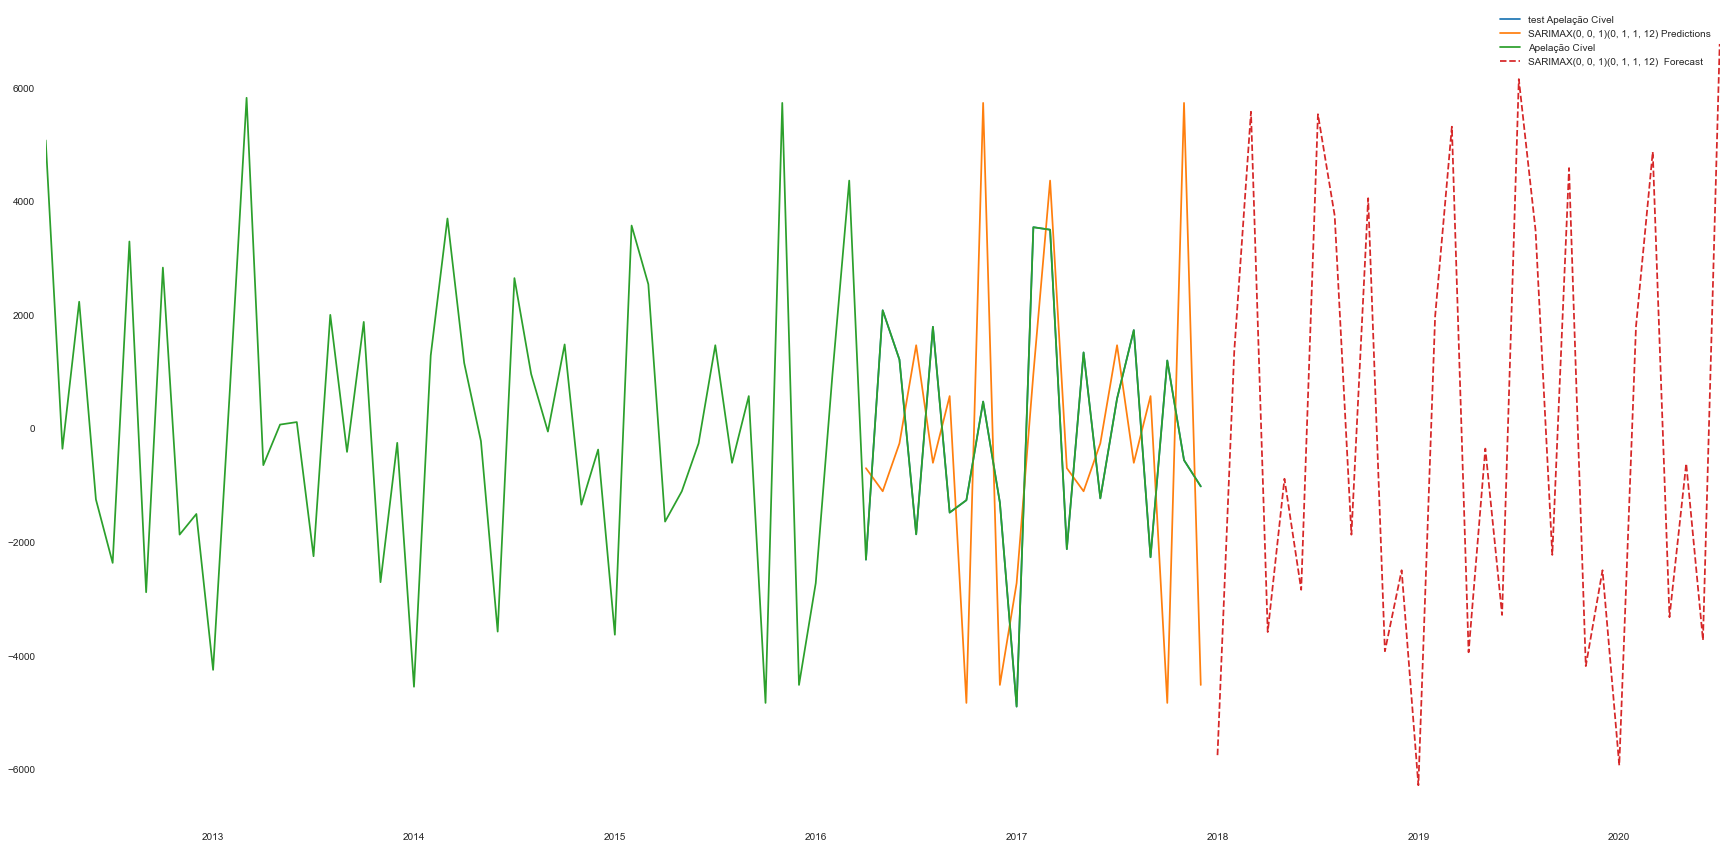

In [13]:
MakePredictionsTestAndForecast('SARIMAX',dfMonth['2012-01-11':],dfUniqueTypes[1],testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,exogField=['weekDay','Feriado','weekType'],holtAlpha=12,holtTrend='add')

#SARIMAX(0, 0, 1) MSE Error:  10011341.4
#SARIMAX(0, 0, 1) RMSE Error: 3164.070385


#SARIMAX(0, 0, 2) MSE Error: 48059676.55
#SARIMAX(0, 0, 2) RMSE Error: 6932.508677

# SARIMAX 

## DAILY

Tamanho do treino:  1559
Tamanho do teste:  668
test Size: 1559
ORDER: (0, 0, 0)
SEASONAL ORDER: (0, 0, 0, 7)
Executando SARIMAX Param order: (0, 0, 0)
incluindo feriados
SARIMAX(0, 0, 0) MSE Error: 0.002994011976
SARIMAX(0, 0, 0) RMSE Error: 0.05471756552
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expected=0
predicted=0.0        , expect

2227
Bias: 0.002994


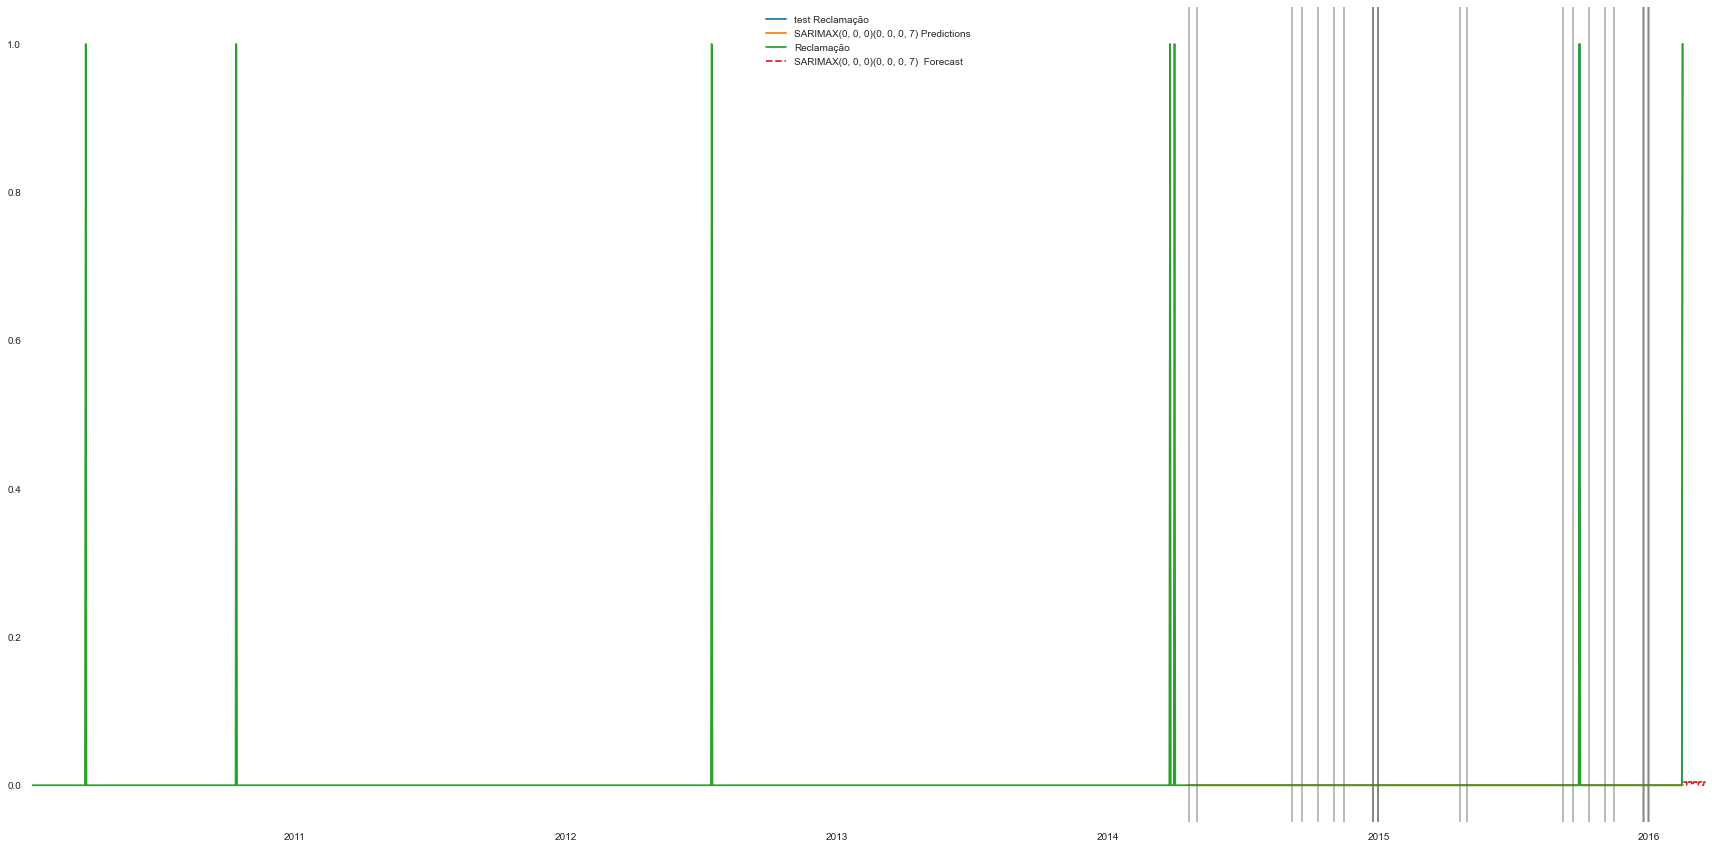

In [14]:
MakePredictionsTestAndForecast('SARIMAX',df['2010-01-11':'2016-02-15'],'Reclamação',testPercentSize=30,
                               seasonal=True,seasonalM=7,futureEstimation=30,exogField='weekType')

## MONTH

Série não estacionaria, aplicado Fuller!
Tamanho do treino:  49
Tamanho do teste:  21
test Size: 49
ORDER: (0, 0, 1)
SEASONAL ORDER: (0, 1, 1, 12)
Executando SARIMAX Param order: (0, 0, 1)
incluindo feriados
SARIMAX(0, 0, 1) MSE Error:  10011341.4
SARIMAX(0, 0, 1) RMSE Error: 3164.070385
predicted=-696.3437235, expected=-2307.0
predicted=-1103.0    , expected=2083.0
predicted=-260.0     , expected=1215.0
predicted=1468.0     , expected=-1861.0
predicted=-602.0     , expected=1793.0
predicted=573.0      , expected=-1478.0
predicted=-4829.0    , expected=-1260.0
predicted=5734.0     , expected=476.0
predicted=-4513.0    , expected=-1303.0
predicted=-2720.0    , expected=-4894.0
predicted=961.0      , expected=3546.0
predicted=4367.0     , expected=3502.0
predicted=-696.3437235, expected=-2122.0
predicted=-1103.0    , expected=1341.0
predicted=-260.0     , expected=-1228.0
predicted=1468.0     , expected=528.0
predicted=-602.0     , expected=1734.0
predicted=573.0      , expected=-2265.0


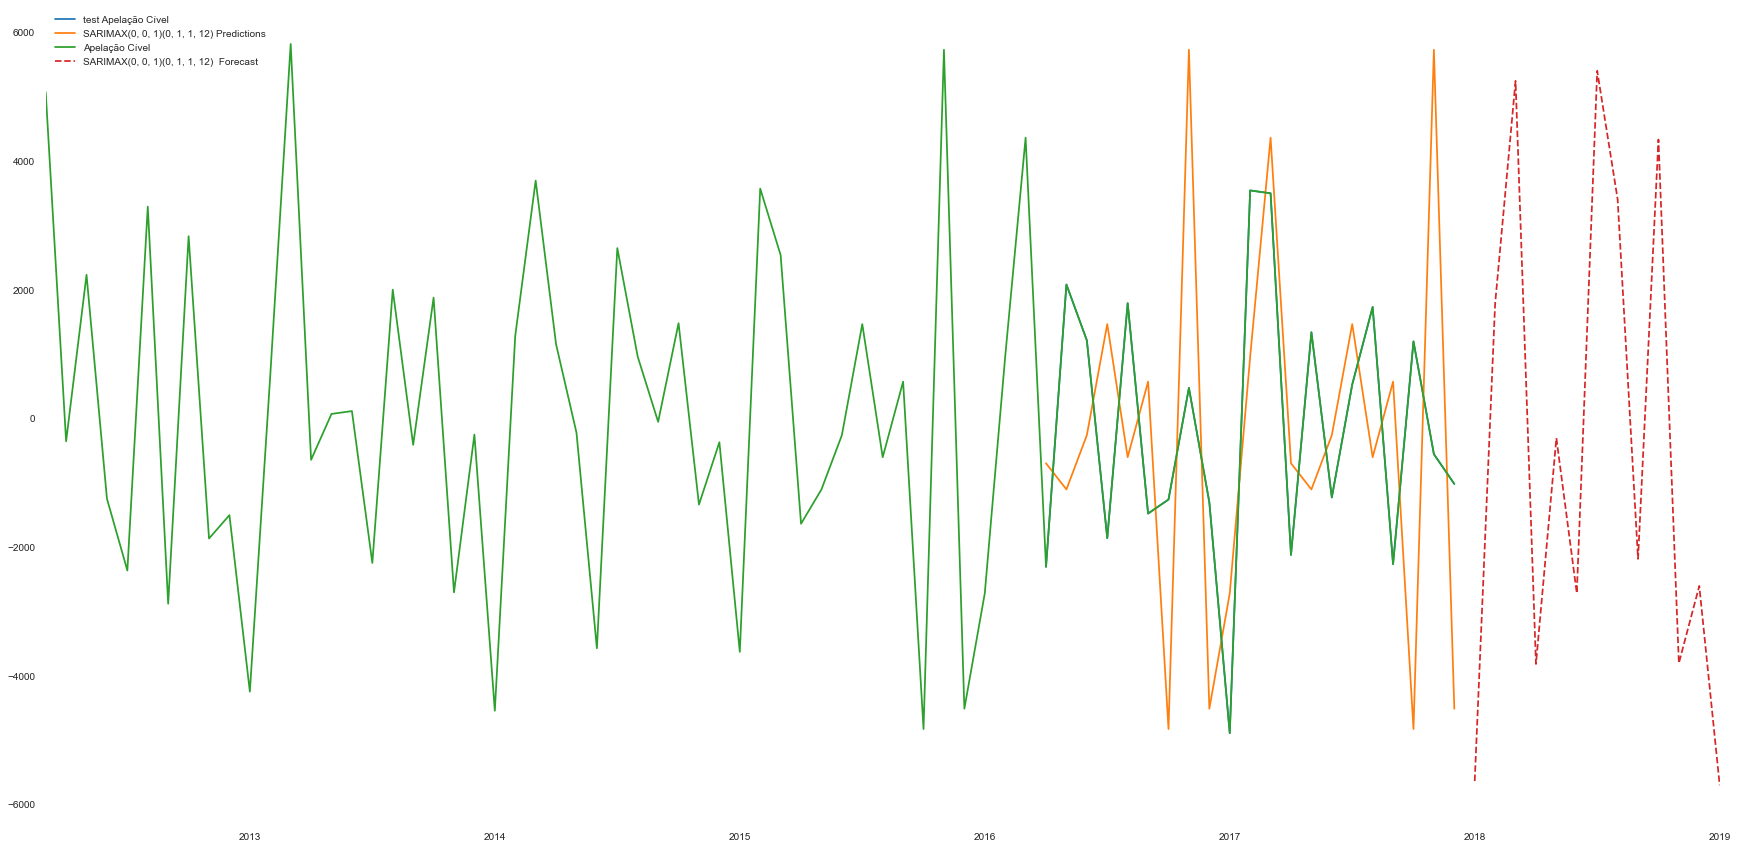

In [15]:
MakePredictionsTestAndForecast('SARIMAX',dfMonth['2012-01-11':],'Apelação Cível',testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=12,exogField=['Feriado'])

#
#Série não estacionaria, aplicado Fuller!
#Tamanho do treino:  84
#Tamanho do teste:  35
#test Size: 84
#Executando SARIMAX Param order: (0, 0, 1)
#incluindo feriados
#SARIMAX(0, 0, 1) MSE Error: 66195472.64
#SARIMAX(0, 0, 1) RMSE Error:  8136.06002
#<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x13ba0e810>
#119
#Bias: -199.898984

# SARIMA 

## DAILY

Tamanho do treino:  1559
Tamanho do teste:  668
test Size: 1559
ORDER: (1, 0, 0)
SEASONAL ORDER: (2, 0, 1, 7)
Executando SARIMA Param order: (1, 0, 0)
SARIMA(1, 0, 0) MSE Error: 1062120.538
SARIMA(1, 0, 0) RMSE Error: 1030.592324
predicted=-225.7130908, expected=0
predicted=-87.08761753, expected=2
predicted=548.4697624, expected=9
predicted=1257.733872, expected=1017
predicted=2548.92363 , expected=863
predicted=3044.242315, expected=5103
predicted=692.472007 , expected=980
predicted=55.62748162, expected=17
predicted=32.91851445, expected=7
predicted=613.5506117, expected=865
predicted=1423.884615, expected=1920
predicted=2679.026694, expected=4838
predicted=2850.801482, expected=19
predicted=553.1990759, expected=466
predicted=-0.8908155537, expected=17
predicted=8.82410227 , expected=20
predicted=600.449721 , expected=576
predicted=1390.114255, expected=892
predicted=2652.55959 , expected=1660
predicted=2890.210371, expected=3103
predicted=581.5692013, expected=555
predicted=10.622

Bias: -53.933547


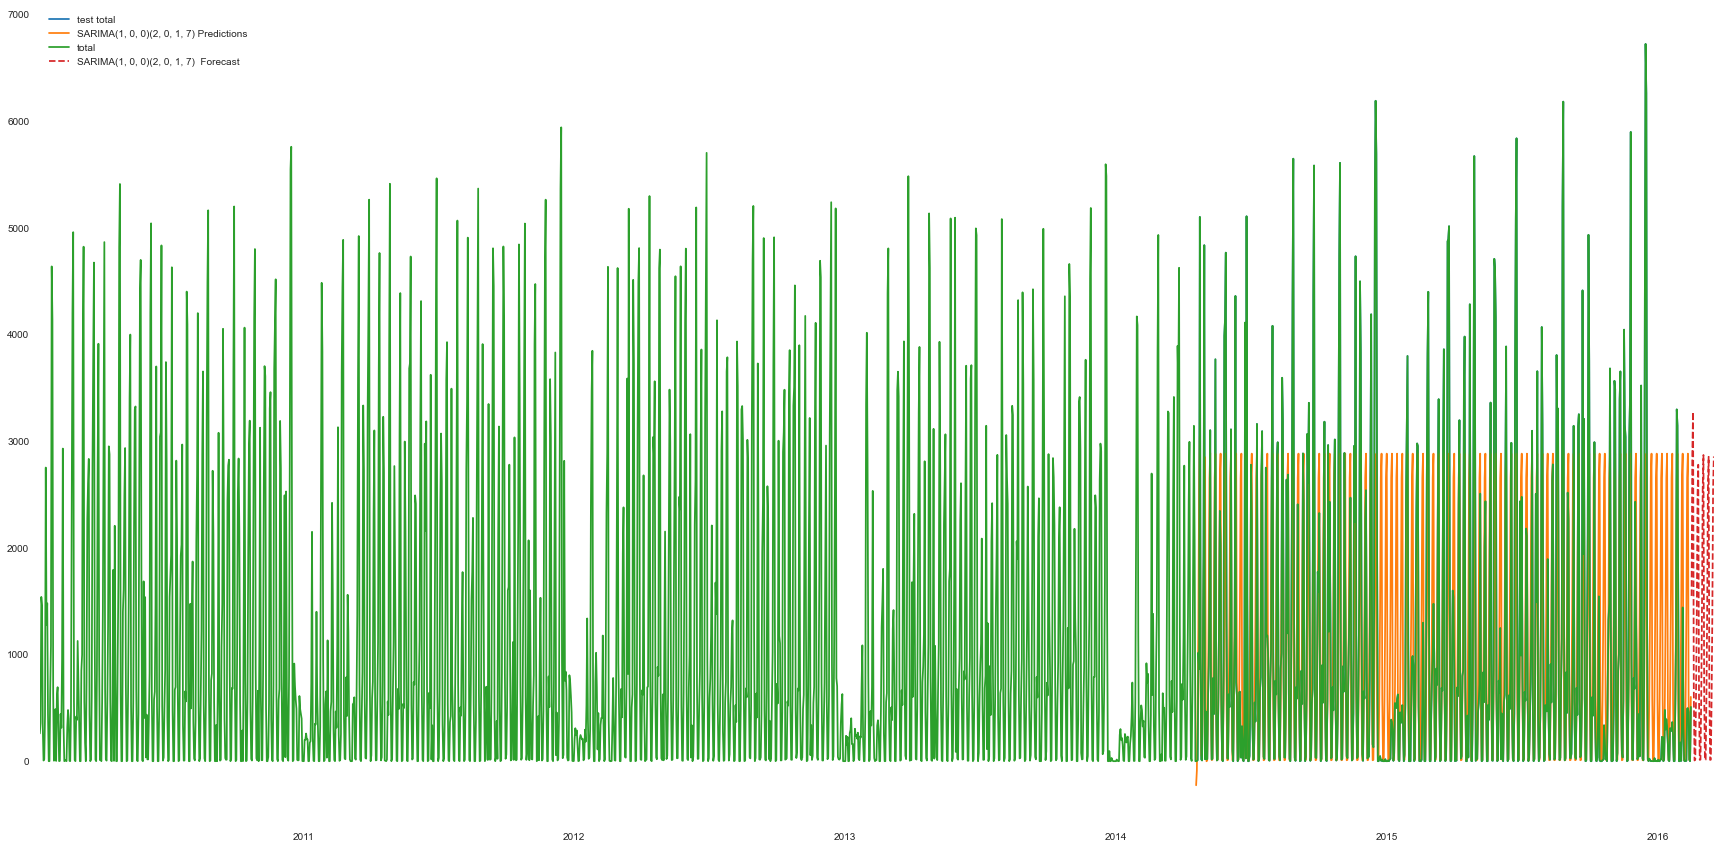

In [16]:
MakePredictionsTestAndForecast('SARIMA',df['2010-01-11':'2016-02-15'],'total',testPercentSize=30,
                               seasonal=True,seasonalM=7,futureEstimation=30)

## MONTH

Tamanho do treino:  27
Tamanho do teste:  8
test Size: 27
ORDER: (0, 0, 0)
SEASONAL ORDER: (0, 1, 0, 12)
Executando SARIMA Param order: (0, 0, 0)
SARIMA(0, 0, 0) MSE Error: 20802322.75
SARIMA(0, 0, 0) RMSE Error: 4560.956342
predicted=32323.0    , expected=36348
predicted=43079.0    , expected=33469
predicted=37558.0    , expected=33513
predicted=42889.0    , expected=41151
predicted=38185.0    , expected=32798
predicted=38016.0    , expected=37399
predicted=37940.0    , expected=36963
predicted=31787.0    , expected=28936
Bias: -2650.000000


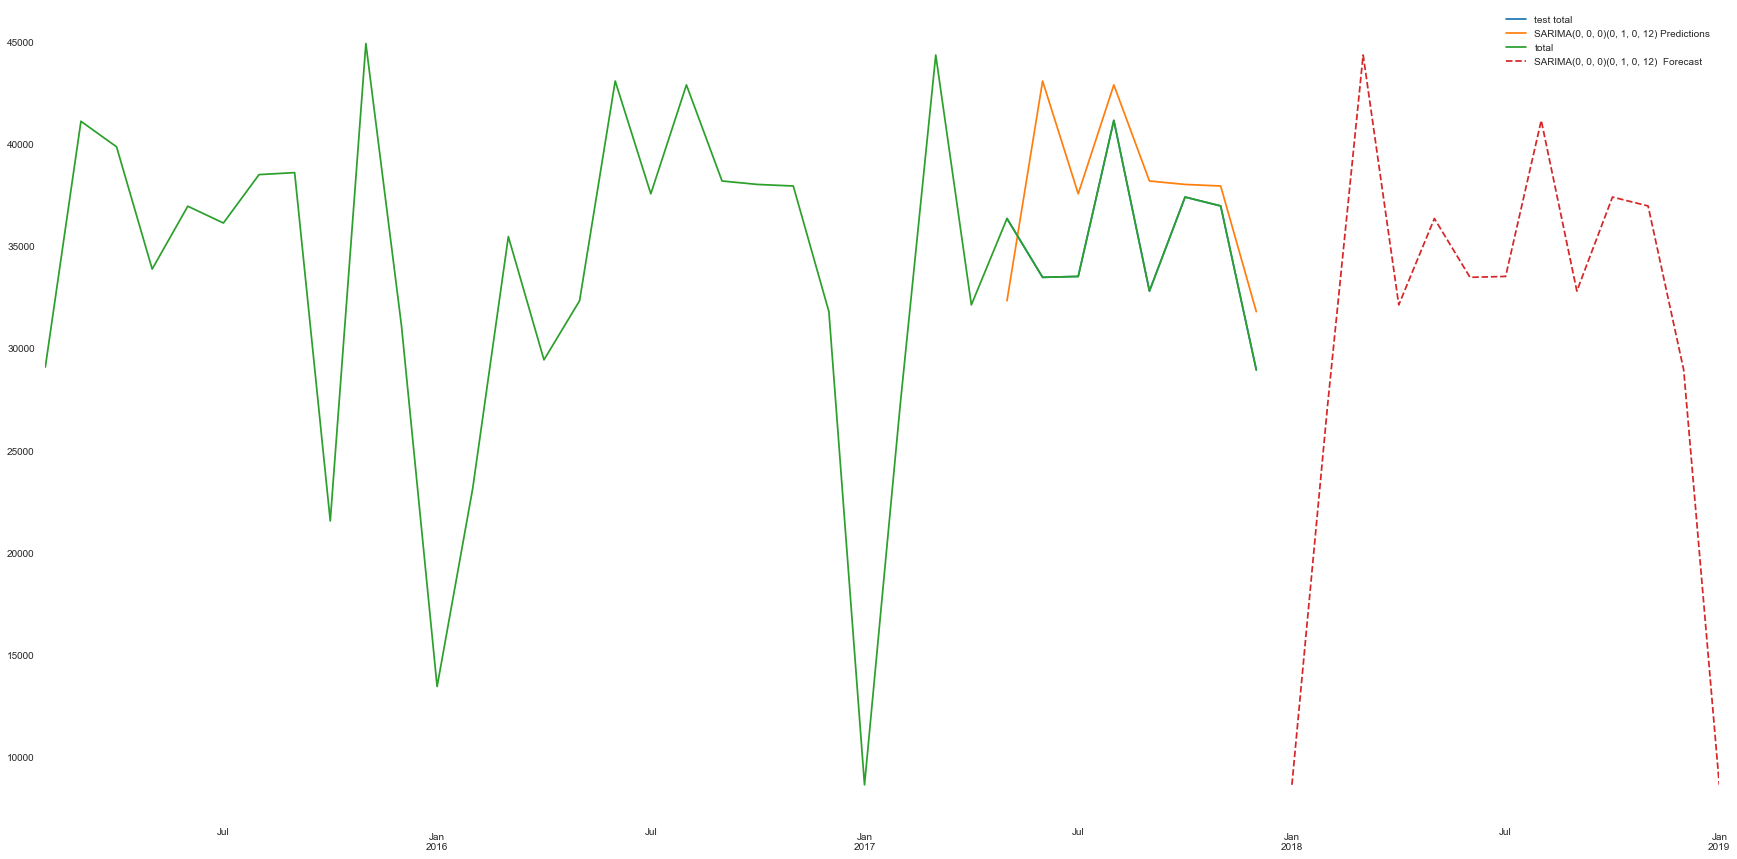

In [17]:
MakePredictionsTestAndForecast('SARIMA',dfMonth['2015-01-11':],'total',testPercentSize=25,
                               seasonal=True,seasonalM=12,futureEstimation=12)

# ARIMA 

## DAILY

Tamanho do treino:  981
Tamanho do teste:  327
test Size: 981
ORDER: (1, 0, 0)
SEASONAL ORDER: (1, 0, 1, 7)
Executando ARIMA Param order: (1, 0, 0)
ARIMA(1, 0, 0) MSE Error: 2426609.787
ARIMA(1, 0, 0) RMSE Error: 1557.757936
predicted=527.6562156, expected=871
predicted=802.5129968, expected=1036
predicted=945.6862372, expected=1173
predicted=1020.265357, expected=1029
predicted=1059.113713, expected=533
predicted=1079.349871, expected=0
predicted=1089.89091 , expected=8
predicted=1095.381751, expected=320
predicted=1098.241937, expected=846
predicted=1099.731811, expected=1198
predicted=1100.507889, expected=4003
predicted=1100.912148, expected=179
predicted=1101.122728, expected=0
predicted=1101.232419, expected=0
predicted=1101.289557, expected=654
predicted=1101.31932 , expected=3466
predicted=1101.334824, expected=5580
predicted=1101.3429  , expected=4441
predicted=1101.347107, expected=305
predicted=1101.349298, expected=0
predicted=1101.35044 , expected=0
predicted=1101.351034, 

predicted=1101.351681, expected=490
predicted=1101.351681, expected=1001
predicted=1101.351681, expected=2511
predicted=1101.351681, expected=2404
predicted=1101.351681, expected=1689
predicted=1101.351681, expected=0
predicted=1101.351681, expected=66
predicted=1101.351681, expected=980
predicted=1101.351681, expected=829
predicted=1101.351681, expected=13
predicted=1101.351681, expected=663
predicted=1101.351681, expected=1157
predicted=1101.351681, expected=58
predicted=1101.351681, expected=22
predicted=1101.351681, expected=913
predicted=1101.351681, expected=439
predicted=1101.351681, expected=3115
predicted=1101.351681, expected=5676
predicted=1101.351681, expected=322
predicted=1101.351681, expected=0
predicted=1101.351681, expected=57
predicted=1101.351681, expected=898
predicted=1101.351681, expected=1972
predicted=1101.351681, expected=5056
predicted=1101.351681, expected=4787
predicted=1101.351681, expected=746
predicted=1101.351681, expected=26
predicted=1101.351681, expec

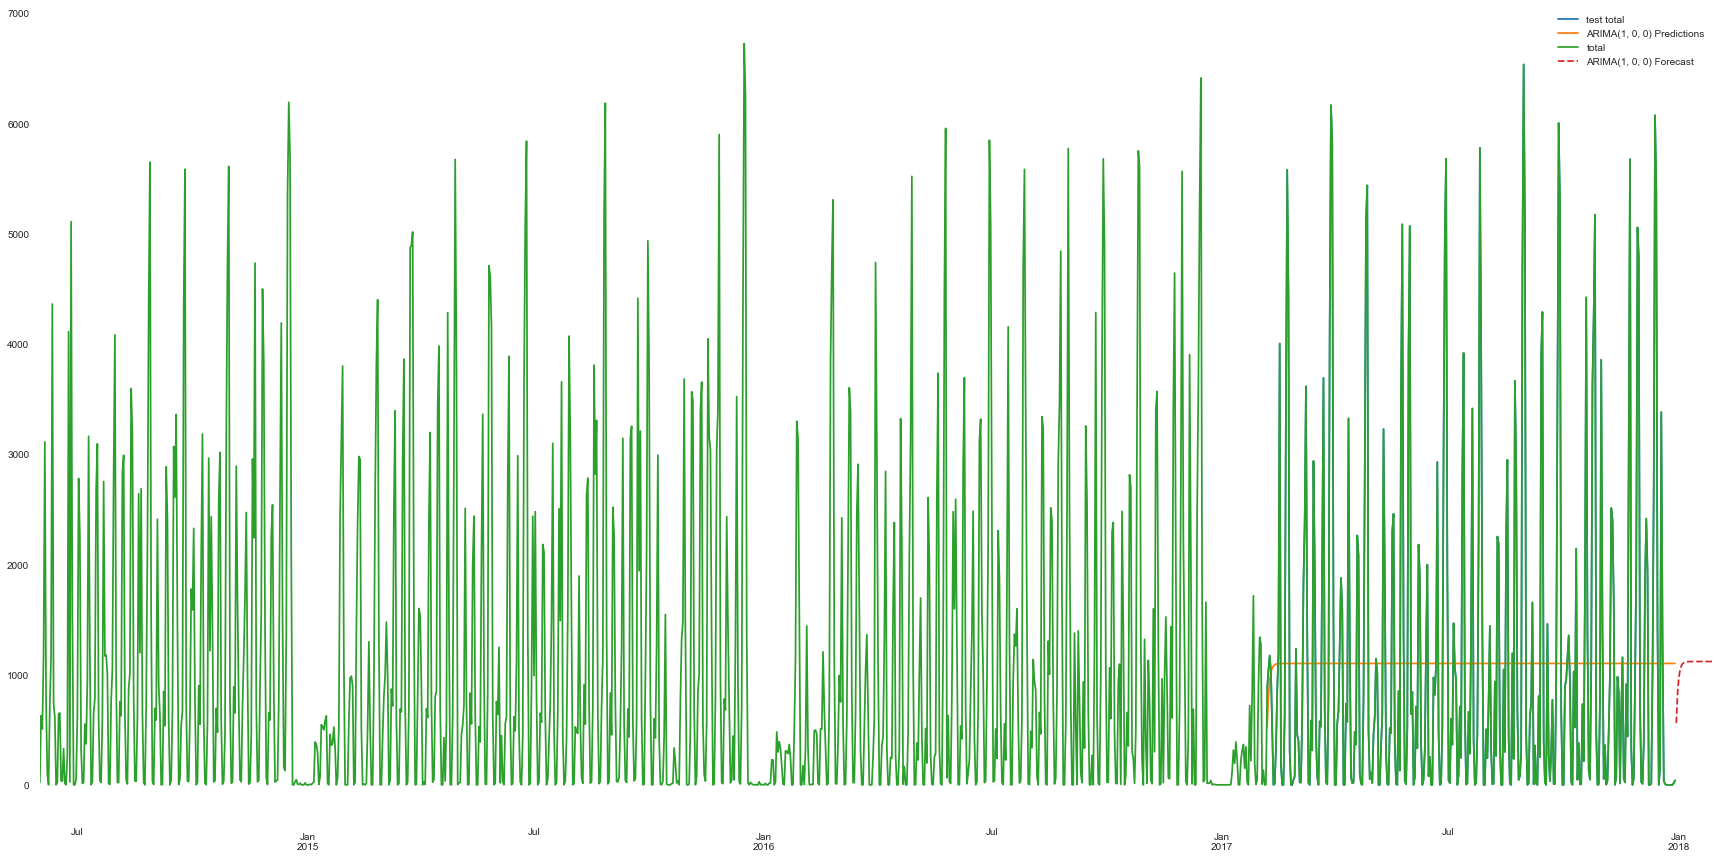

In [18]:
MakePredictionsTestAndForecast('ARIMA',df['2014-06-01':],'total',testPercentSize=25,
                               seasonal=True,seasonalM=7,futureEstimation=30)

## MONTH


Série não estacionaria, aplicado Fuller!
Tamanho do treino:  162
Tamanho do teste:  53
test Size: 162
ORDER: (3, 0, 2)
SEASONAL ORDER: (0, 0, 0, 0)
Executando ARIMA Param order: (3, 0, 2)
ARIMA(3, 0, 2) MSE Error: 95043336.25
ARIMA(3, 0, 2) RMSE Error: 9749.017194
predicted=4187.54978 , expected=10104.0
predicted=673.6382112, expected=-5315.0
predicted=1981.994406, expected=6754.0
predicted=-1561.269691, expected=-4999.0
predicted=1575.014645, expected=-6391.0
predicted=-1313.911294, expected=-15748.0
predicted=1720.162253, expected=6262.0
predicted=-1296.553599, expected=11409.0
predicted=1692.417121, expected=3120.0
predicted=-1299.94362, expected=-43.0
predicted=1686.8384  , expected=-10137.0
predicted=-1292.204066, expected=8800.0
predicted=1681.382427, expected=5061.0
predicted=-1286.344178, expected=-2495.0
predicted=1675.293264, expected=4617.0
predicted=-1280.420735, expected=-5222.0
predicted=1669.369576, expected=-344.0
predicted=-1274.487132, expected=-20072.0
predicted=1663

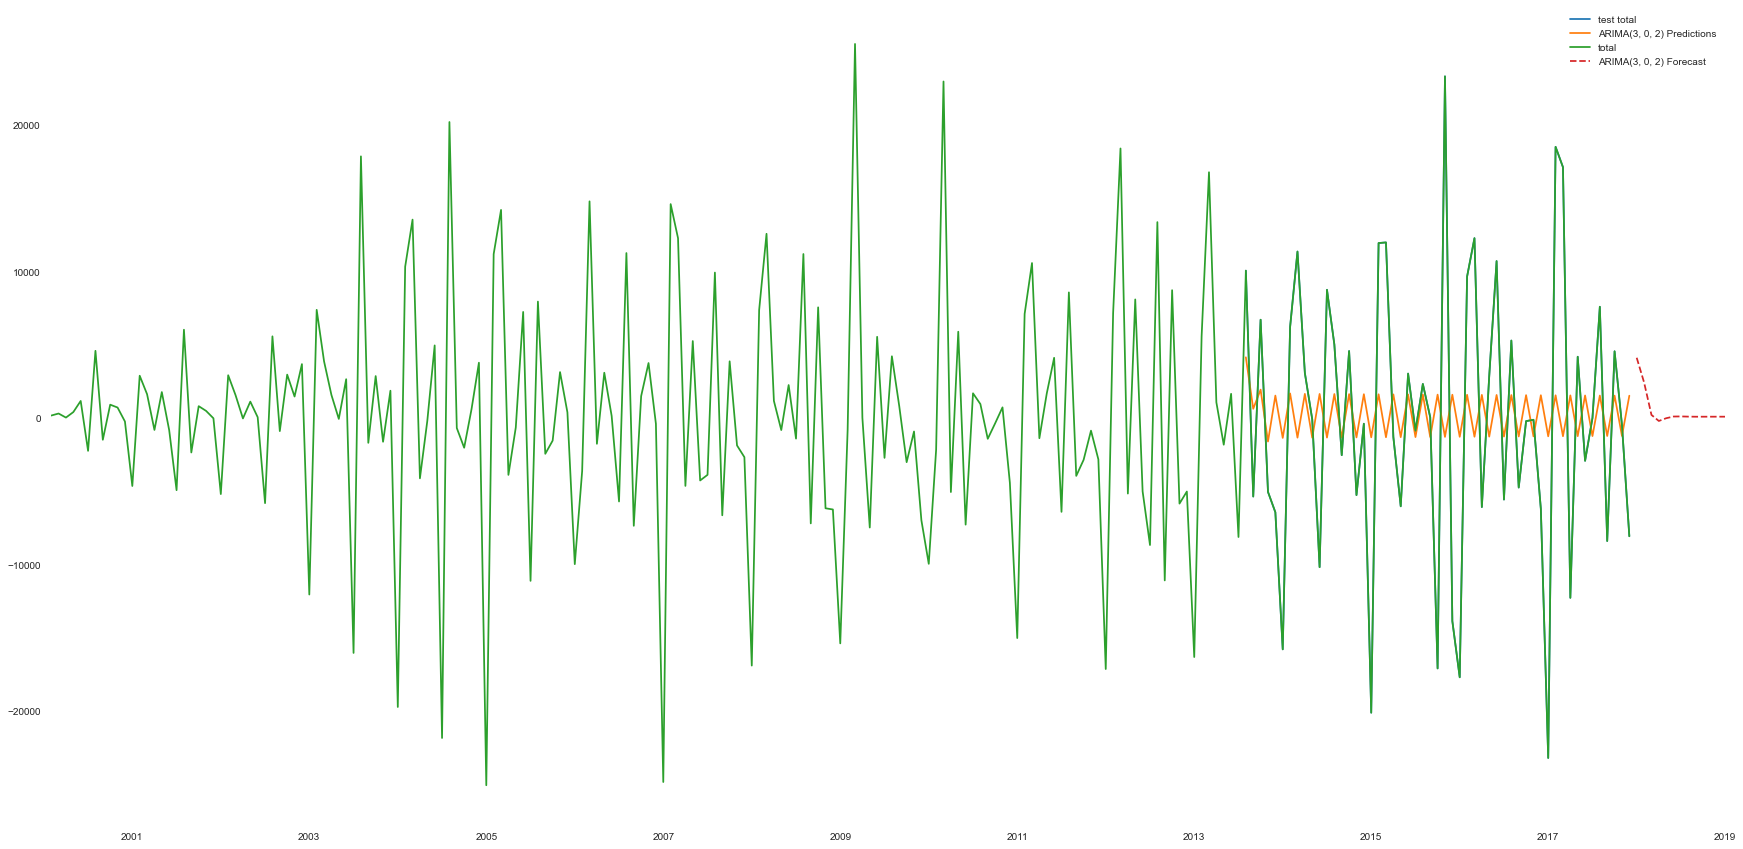

In [19]:
MakePredictionsTestAndForecast('ARIMA',dfMonth,'total',testPercentSize=25,
                               seasonal=False,seasonalM=12,futureEstimation=12)

Série não estacionaria, aplicado Fuller!
Tamanho do treino:  33
Tamanho do teste:  14
test Size: 33
Série não estacionaria, aplicado Fuller!
Tamanho do treino:  33
Tamanho do teste:  14
test Size: 33
ORDER: (0, 0, 1)
SEASONAL ORDER: (0, 1, 1, 12)
Executando SARIMA Param order: (0, 0, 1)
SARIMA(0, 0, 1) MSE Error: 45320229.88
SARIMA(0, 0, 1) RMSE Error: 6732.030146
predicted=7106.31561 , expected=-76.0
predicted=-7471.722945, expected=-6153.0
predicted=-14291.17431, expected=-23162.0
predicted=8956.720252, expected=18557.0
predicted=11029.56459, expected=17170.0
predicted=-2977.595719, expected=-12230.0
predicted=-57.71363549, expected=4226.0
predicted=4922.389759, expected=-2879.0
predicted=-1826.224584, expected=44.0
predicted=4053.078268, expected=7638.0
predicted=-2737.125586, expected=-8353.0
predicted=-3854.9839 , expected=4601.0
predicted=8949.00659 , expected=-436.0
predicted=-7471.722945, expected=-8027.0
Bias: -957.772247
Série não estacionaria, aplicado Fuller!
Tamanho do tre

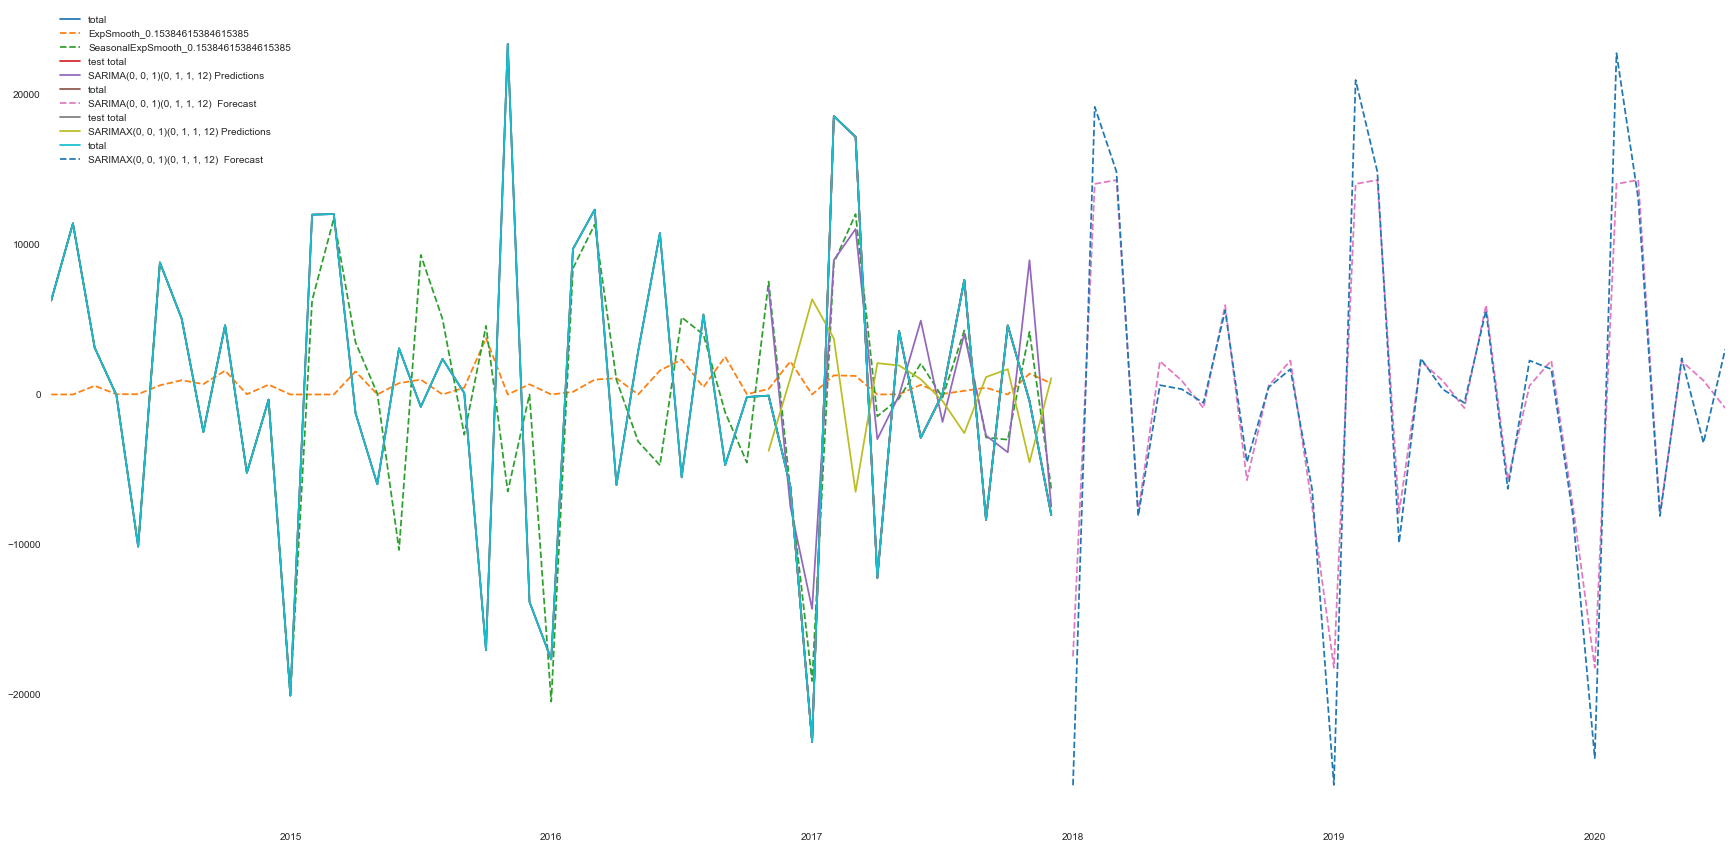

In [20]:
for what in ['SMOOTHING','SARIMA','SARIMAX']:
    MakePredictionsTestAndForecast(what,dfMonth['2014-01-01':],'total',testPercentSize=30,
                               seasonal=True,seasonalM=12,futureEstimation=30,exogField='weekType',figsizeX=30,figsizeY=15)

In [21]:
# CORRELATION
from scipy import stats
stats.pearsonr(df['Agravo de Instrumento'],df['Apelação Cível'])[0]

0.7998840793386222

In [22]:
rowCorr=[]
for i in dfUniqueTypes:
    for i2 in dfUniqueTypes:
        if i != i2:
            result = stats.pearsonr(df[i],df[i2])
            print(f'{i} e {i2}: {result}')
            rowCorr.append({'type':i,'type_2':i2,'valor':result[0],'valor_2':result[1]})

Agravo de Instrumento e Apelação Cível: (0.7998840793386222, 0.0)
Agravo de Instrumento e Apelação e Reexame Necessário: (0.5597368203994513, 0.0)
Agravo de Instrumento e Agravo: (0.7051798442906133, 0.0)
Agravo de Instrumento e Reexame Necessário: (0.47723947803444655, 0.0)
Agravo de Instrumento e Agravo Regimental: (0.4987562592510987, 0.0)
Agravo de Instrumento e Embargos de Declaração: (0.8121211795778395, 0.0)
Agravo de Instrumento e Apelação Crime: (0.5741324935852816, 0.0)
Agravo de Instrumento e Ação Rescisória: (0.3224634608413448, 7.368025141691345e-159)
Agravo de Instrumento e Conflito de Competência: (0.5606242557184403, 0.0)
Agravo de Instrumento e Agravo Interno: (0.1886265588701032, 1.0919173858698402e-53)
Agravo de Instrumento e Exceção de Suspeição: (0.3352273213937645, 2.6509604371103243e-172)
Agravo de Instrumento e Mandado de Segurança: (0.2652972222784075, 2.9096258593621666e-106)
Agravo de Instrumento e Habeas Corpus: (0.5588091057137077, 0.0)
Agravo de Instrument

Agravo e Investigação Contra Magistrado: (0.0083956589627109, 0.49622023871843673)
Agravo e Ação Civil Improbidade Administrativa: (0.037802988614756367, 0.0021775212655176274)
Agravo e Suspensão de Execução de Sentença: (0.011157255341232578, 0.3658457724234537)
Agravo e Incidente de Prevenção ou Composição de Divergência: (-0.004966299615010267, 0.6873141702126953)
Agravo e Embargos de Terceiros: (0.007273196029838981, 0.5555438172529074)
Agravo e Mandado de Segurança Coletivo: (-0.003733712461708461, 0.7621912296785867)
Agravo e Impugnação ao Cumprimento de Sentença: (0.010774486369496135, 0.38252278434078213)
Agravo e Oposição: (0.0030710523570002734, 0.8034397087948603)
Agravo e Cumprimento de Sentença: (0.006960031441268384, 0.572691855156861)
Agravo e Liquidação Provisória por Artigos: (0.03903159466102455, 0.0015531149427335284)
Agravo e Notificação Para Explicações: (-0.004800581017649223, 0.697223262671293)
Agravo e Medidas Protetivas de Urgencia: (0.011205101462699612, 0.363

Ação Rescisória e Agravo de Instrumento: (0.3224634608413448, 7.368025141691345e-159)
Ação Rescisória e Apelação Cível: (0.1947109216587846, 3.7206345747872977e-57)
Ação Rescisória e Apelação e Reexame Necessário: (0.17875712269955552, 2.5951663573024398e-48)
Ação Rescisória e Agravo: (0.14272278913890762, 3.014722236818852e-31)
Ação Rescisória e Reexame Necessário: (0.1742526429114445, 5.838633028271585e-46)
Ação Rescisória e Agravo Regimental: (0.1933146456403818, 2.381103873664766e-56)
Ação Rescisória e Embargos de Declaração: (0.2083989137056828, 2.1720066840781957e-65)
Ação Rescisória e Apelação Crime: (0.10513586976402813, 1.2902659584170248e-17)
Ação Rescisória e Conflito de Competência: (0.19063027764415838, 8.11369069925469e-55)
Ação Rescisória e Agravo Interno: (0.039099201291390155, 0.0015240901010984496)
Ação Rescisória e Exceção de Suspeição: (0.07849449653753746, 1.8716465629577743e-10)
Ação Rescisória e Mandado de Segurança: (0.32326057903566896, 1.1133352865266338e-159)

Mandado de Segurança e Correição Parcial: (0.16882077260203096, 3.3018009580994647e-43)
Mandado de Segurança e Conflito de Jurisdição: (0.161162148637751, 1.756116101336162e-39)
Mandado de Segurança e Agravo Lei: (-0.005859260478780396, 0.6348758150127252)
Mandado de Segurança e Queixa: (0.011724434757558636, 0.34198294335907986)
Mandado de Segurança e Agravo em Execução: (0.08769472030883753, 1.0710557765692695e-12)
Mandado de Segurança e Recurso de Agravo: (-0.004006240898218054, 0.7454140104349529)
Mandado de Segurança e Agravo Inominado: (0.021995222954000818, 0.07461125614286557)
Mandado de Segurança e Cautelar Incidental: (-0.00398132849612934, 0.746942784393549)
Mandado de Segurança e Desaforamento: (0.07651653304971846, 5.282079718391529e-10)
Mandado de Segurança e Embargos Infringentes: (0.11560952652360995, 5.39138062006664e-21)
Mandado de Segurança e Embargos à Execução: (0.053379493065246954, 1.495867239453468e-05)
Mandado de Segurança e Cautelar Inominada: (0.0893959422295

Medida Cautelar e Mandado de Segurança: (0.050189082699146084, 4.697205216070091e-05)
Medida Cautelar e Habeas Corpus: (0.10490088797856295, 1.5233953801403218e-17)
Medida Cautelar e Outros Feitos: (0.1125259064989253, 5.752925202321891e-20)
Medida Cautelar e Impugnação ao Valor da Causa: (0.007457239396999296, 0.545584423317413)
Medida Cautelar e Medida Cautelar Inominada: (0.07507467641221886, 1.1072872434016497e-09)
Medida Cautelar e Outros Incidentes: (0.008047510878295803, 0.5142519026891044)
Medida Cautelar e Recurso Crime: (-0.012647907996443605, 0.30531273498530065)
Medida Cautelar e Recurso em Sentido Estrito: (0.1313036865634188, 1.1587061971064828e-26)
Medida Cautelar e Processo Crime: (0.10914808461602336, 7.148028151415335e-19)
Medida Cautelar e Recurso de Ofício: (0.12350919289032074, 9.331943098577681e-24)
Medida Cautelar e Correição Parcial: (0.1230686487863011, 1.3453580549559421e-23)
Medida Cautelar e Conflito de Jurisdição: (-0.017619340719196165, 0.15326511401522785

Recurso em Sentido Estrito e Inquérito Policial: (0.08574792220671855, 3.3458063309991243e-12)
Recurso em Sentido Estrito e Interpelação Judicial: (-0.0048652906886605925, 0.693347707339504)
Recurso em Sentido Estrito e Exceção de Incompetência: (0.07926555306849983, 1.2404046342551557e-10)
Recurso em Sentido Estrito e Representação: (-0.02001548370173945, 0.10472991215516773)
Recurso em Sentido Estrito e Pedido de Assistência Judiciária Gratuita: (0.01800333312282712, 0.14450415639214842)
Recurso em Sentido Estrito e Impugnação à Assistência Judiciária: (0.02674162156593897, 0.030181773929138202)
Recurso em Sentido Estrito e Restauração de Autos: (0.14397042701848772, 9.007300015456694e-32)
Recurso em Sentido Estrito e Declaração de Inconstitucionalidade: (0.023429272741035574, 0.057549207530901224)
Recurso em Sentido Estrito e Uniformização de Jurisprudência: (-0.01195154821503748, 0.33271328218592516)
Recurso em Sentido Estrito e Mandado de Injunção: (0.01537690403607121, 0.21264892

Recurso de Ofício e Embargos de Nulidade: (0.0052249454835431395, 0.6719558094774055)
Recurso de Ofício e Recurso Cível: (0.15129952280948614, 5.99226536510172e-35)
Recurso de Ofício e Incidente de Inconstitucionalidade: (-0.005048682169024734, 0.6824079137624847)
Recurso de Ofício e Agravo de Petição: (0.03972427971227195, 0.0012784383333410301)
Recurso de Ofício e Processo de Execução: (-0.003078261761428182, 0.8029877574174659)
Recurso de Ofício e Intervenção Federal no Estado: (0.0010979762437570268, 0.9290923048978507)
Recurso de Ofício e Pedido de Arquivamento: (-0.004353650872227335, 0.7242017265343685)
Recurso de Ofício e Reclamação: (0.00300682309838146, 0.8074690698448563)
Recurso de Ofício e Outros Cíveis: (0.061731992801696084, 5.50199519021232e-07)
Recurso de Ofício e Exceção Suspeição Impedimento: (0.02846884480990882, 0.021012390287986685)
Recurso de Ofício e Mandado de Segurança Crime: (-0.020275755253368426, 0.10029119956056737)
Recurso de Ofício e Impugnação: (-0.0053

Agravo Lei e Uniformização de Jurisprudência: (-0.00280798943638668, 0.8199746701213093)
Agravo Lei e Mandado de Injunção: (-0.003333987475204314, 0.7870002046319083)
Agravo Lei e Apelação Rec: (-0.0021834772284969285, 0.8595375117048228)
Agravo Lei e Notícia Crime: (-0.001505478822772735, 0.9028883012611383)
Agravo Lei e Ação Civil Pública: (-0.001994872575041031, 0.8715600848840184)
Agravo Lei e Apelação Recurso de Ofício: (-0.0016665455005228909, 0.8925585752100962)
Agravo Lei e Recurso Oficioso em Sentido Estrito: (-0.0030809566719686363, 0.8028188326920412)
Agravo Lei e Prefeito: (-0.0021244010142368952, 0.8632999511175972)
Agravo Lei e Revisão Criminal: (-0.009422235234458622, 0.44507340364185854)
Agravo Lei e Reabilitação: (-0.0017169025261961769, 0.8893326684987748)
Agravo Lei e Recurso Inominado: (-0.0006728605039907184, 0.9565106377161725)
Agravo Lei e Habilitação: (-0.001505478822772723, 0.9028883012611383)
Agravo Lei e Ação Direta de Inconstitucionalidade: (-0.0082011531368

Recurso de Agravo e Termo Circunstanciado: (-0.001326630917981468, 0.9143776079850374)
Recurso de Agravo e Exceção da Verdade: (-0.0006133312597017186, 0.9603549030641969)
Recurso de Agravo e Inquérito Policial: (-0.001239235318880327, 0.9199986229346161)
Recurso de Agravo e Interpelação Judicial: (-0.00015220700152207225, 0.990157695842369)
Recurso de Agravo e Exceção de Incompetência: (-0.0006913766112857765, 0.9553151109278234)
Recurso de Agravo e Representação: (-0.0006433149951901048, 0.9584184997257078)
Recurso de Agravo e Pedido de Assistência Judiciária Gratuita: (-0.0005700707277488611, 0.9631491548585404)
Recurso de Agravo e Impugnação à Assistência Judiciária: (-0.0014020482296685395, 0.9095304280437957)
Recurso de Agravo e Restauração de Autos: (-0.0018405273700664295, 0.881421047054436)
Recurso de Agravo e Declaração de Inconstitucionalidade: (-0.00015220700152207217, 0.990157695842369)
Recurso de Agravo e Uniformização de Jurisprudência: (-0.0008983656032085385, 0.9419579

Desaforamento e Crimes Ambientais: (0.02430607187090654, 0.04881455650664494)
Desaforamento e Embargos Infringentes e de Nulidade: (-0.019445194294904888, 0.11500051711541504)
Desaforamento e Exceção de Impedimento: (0.07171446084252142, 5.89588251912913e-09)
Desaforamento e Intervenção no Estado: (-0.008424676527093913, 0.4947327016854356)
Desaforamento e Procedimento Investigatório do MP: (0.04593053677835559, 0.00019573000194890135)
Desaforamento e Ação Penal: (0.07755054460514392, 3.08065746061722e-10)
Desaforamento e Crimes contra a honra: (0.018229083669487136, 0.13953570232707155)
Desaforamento e Declaratória de Constitucionalidade: (-0.0025884319315823325, 0.8338369335946192)
Desaforamento e Arresto: (-0.0018301584740930946, 0.8820841824104664)
Desaforamento e Outras Medidas Provisionais: (-0.0018301584740930956, 0.8820841824104664)
Desaforamento e Representação Criminal: (0.057703984325951814, 2.8604548147157684e-06)
Desaforamento e Incidente de Uniformizacao Jurisprudencia: (

Carta Testemunhável e Agravo de Instrumento: (0.20134059266910465, 4.548635481381135e-61)
Carta Testemunhável e Apelação Cível: (0.22928994922990897, 3.933863161042812e-79)
Carta Testemunhável e Apelação e Reexame Necessário: (0.15803307151979729, 5.18704700860591e-38)
Carta Testemunhável e Agravo: (0.2590194322419693, 3.2805789042220367e-101)
Carta Testemunhável e Reexame Necessário: (0.10843334867976107, 1.2063066120925018e-18)
Carta Testemunhável e Agravo Regimental: (0.2100457805877168, 2.0205686392930684e-66)
Carta Testemunhável e Embargos de Declaração: (0.2067708966980515, 2.2273947567014972e-64)
Carta Testemunhável e Apelação Crime: (0.3380690758179216, 2.1959373964848245e-175)
Carta Testemunhável e Ação Rescisória: (0.03579072553538539, 0.003712209468950039)
Carta Testemunhável e Conflito de Competência: (0.23172240985813186, 7.959688987284796e-81)
Carta Testemunhável e Agravo Interno: (0.04446961285306597, 0.0003110961777941964)
Carta Testemunhável e Exceção de Suspeição: (0.

Exceção da Verdade e Restauração de Autos: (0.007541766907123131, 0.5410401311769266)
Exceção da Verdade e Declaração de Inconstitucionalidade: (-0.0006133312597017177, 0.9603549030641969)
Exceção da Verdade e Uniformização de Jurisprudência: (-0.0036200417955719595, 0.7692226208444155)
Exceção da Verdade e Mandado de Injunção: (-0.0025440294222496647, 0.8366468241492101)
Exceção da Verdade e Apelação Rec: (-0.0028149247017857804, 0.8195376870281028)
Exceção da Verdade e Notícia Crime: (0.06891108347912481, 2.2494156991155914e-08)
Exceção da Verdade e Ação Civil Pública: (-0.00257177680404006, 0.834890660890381)
Exceção da Verdade e Apelação Recurso de Ofício: (-0.0021484996659668605, 0.8617647794822015)
Exceção da Verdade e Recurso Oficioso em Sentido Estrito: (-0.003971949387824087, 0.747518600963896)
Exceção da Verdade e Prefeito: (-0.002738764028966293, 0.8243395249910453)
Exceção da Verdade e Revisão Criminal: (-0.00829245952665263, 0.50152985419949)
Exceção da Verdade e Reabilita

Interpelação Judicial e Incidente de Assunção de Competência: (-0.00026367039543891656, 0.982950898785784)
Interpelação Judicial e Agravo em Rec: (-0.00021526958923344088, 0.9860801736092338)
Interpelação Judicial e Tutela Cautelar Antecedente: (-0.0003229658461313716, 0.9791176109236068)
Interpelação Judicial e Tutela Antecipada Antecedente: (-0.00035526985623522315, 0.9770294426850183)
Interpelação Judicial e Tutela Provisoria: (-0.0004568992623644644, 0.9704610944326162)
Interpelação Judicial e Agravo de Instrumento em Recurso Extraordinario: (-0.00015220700152207133, 0.990157695842369)
Interpelação Judicial e Interpelação: (-0.00015220700152207133, 0.990157695842369)
Exceção de Incompetência e Agravo de Instrumento: (0.0832852010050473, 1.3637673904198393e-11)
Exceção de Incompetência e Apelação Cível: (0.07374848660269268, 2.16134876689573e-09)
Exceção de Incompetência e Apelação e Reexame Necessário: (0.04811097328572305, 9.560842674180948e-05)
Exceção de Incompetência e Agravo: 

Pedido de Assistência Judiciária Gratuita e Suspenção de Liminar ou Antecipação de Tutela: (-0.0036864048860663205, 0.7651152148824796)
Pedido de Assistência Judiciária Gratuita e Petição: (-0.003198396601711726, 0.7954664112589167)
Pedido de Assistência Judiciária Gratuita e Intervenção em Município: (-0.0021520379405770844, 0.8615394223417955)
Pedido de Assistência Judiciária Gratuita e Crimes Ambientais: (-0.0015089545530674088, 0.9026652114333095)
Pedido de Assistência Judiciária Gratuita e Embargos Infringentes e de Nulidade: (0.0040055393516245956, 0.7454570478480754)
Pedido de Assistência Judiciária Gratuita e Exceção de Impedimento: (-0.0027385521063059788, 0.8243528957210994)
Pedido de Assistência Judiciária Gratuita e Intervenção no Estado: (-0.002624177931492496, 0.8315763851071598)
Pedido de Assistência Judiciária Gratuita e Procedimento Investigatório do MP: (-0.0017112543601764737, 0.8896944038142989)
Pedido de Assistência Judiciária Gratuita e Ação Penal: (-0.00708502395

Declaração de Inconstitucionalidade e Embargos Infringentes: (-0.002133495540367072, 0.8627205358214346)
Declaração de Inconstitucionalidade e Embargos à Execução: (-0.0005374869735734181, 0.96525408091617)
Declaração de Inconstitucionalidade e Cautelar Inominada: (-0.0029390512514631535, 0.8117262141160336)
Declaração de Inconstitucionalidade e Carta Testemunhável: (-0.0020056707886896485, 0.870870925805947)
Declaração de Inconstitucionalidade e Habeas Data: (-0.0009421054102857019, 0.939137339066021)
Declaração de Inconstitucionalidade e Termo Circunstanciado: (-0.0013266309179814674, 0.9143776079850374)
Declaração de Inconstitucionalidade e Exceção da Verdade: (-0.0006133312597017177, 0.9603549030641969)
Declaração de Inconstitucionalidade e Inquérito Policial: (-0.0012392353188803319, 0.9199986229346161)
Declaração de Inconstitucionalidade e Interpelação Judicial: (-0.00015220700152207212, 0.990157695842369)
Declaração de Inconstitucionalidade e Exceção de Incompetência: (-0.000691

Mandado de Injunção e Interpelação: (-0.001066649194060289, 0.9311103093450016)
Apelação Rec e Agravo de Instrumento: (0.03173770568810834, 0.010085873937805133)
Apelação Rec e Apelação Cível: (0.08971740086177356, 3.193920269983263e-13)
Apelação Rec e Apelação e Reexame Necessário: (0.04601430222408694, 0.00019052107476213648)
Apelação Rec e Agravo: (0.04194638839962816, 0.0006711632284174547)
Apelação Rec e Reexame Necessário: (0.025169961893848486, 0.04132492806792643)
Apelação Rec e Agravo Regimental: (0.03187756186142842, 0.009760104022260428)
Apelação Rec e Embargos de Declaração: (0.07193717706550792, 5.289302583810145e-09)
Apelação Rec e Apelação Crime: (0.05440100623696387, 1.0229398988032144e-05)
Apelação Rec e Ação Rescisória: (0.0008160024144857829, 0.9472711629012093)
Apelação Rec e Conflito de Competência: (0.019868682409615035, 0.10730143755047158)
Apelação Rec e Agravo Interno: (0.021349760826915778, 0.08353812717770147)
Apelação Rec e Exceção de Suspeição: (0.012116072

Ação Civil Pública e Carta Testemunhável: (-0.007542031407922496, 0.5410259410498588)
Ação Civil Pública e Habeas Data: (-0.0039503690751256145, 0.7488440270796158)
Ação Civil Pública e Termo Circunstanciado: (-0.0001968025370697878, 0.9872741896585296)
Ação Civil Pública e Exceção da Verdade: (-0.00257177680404006, 0.834890660890381)
Ação Civil Pública e Inquérito Policial: (-0.00519627297228209, 0.6736517928487318)
Ação Civil Pública e Interpelação Judicial: (-0.0006382235207077792, 0.958747299290454)
Ação Civil Pública e Exceção de Incompetência: (0.00013047483642471074, 0.9915629264999523)
Ação Civil Pública e Representação: (-0.0026975024607840173, 0.8269437768129483)
Ação Civil Pública e Pedido de Assistência Judiciária Gratuita: (-0.0023903798332401737, 0.8463859865678178)
Ação Civil Pública e Impugnação à Assistência Judiciária: (-0.005878968433731446, 0.6337376822545995)
Ação Civil Pública e Restauração de Autos: (0.009392512116788551, 0.4465107527195356)
Ação Civil Pública e 

Recurso Oficioso em Sentido Estrito e Ação Civil Improbidade Administrativa: (-0.0019718433433705503, 0.8730301719226216)
Recurso Oficioso em Sentido Estrito e Suspensão de Execução de Sentença: (-0.0017075364237267902, 0.8899325306182593)
Recurso Oficioso em Sentido Estrito e Incidente de Prevenção ou Composição de Divergência: (-0.0009856965497114206, 0.9363270806897753)
Recurso Oficioso em Sentido Estrito e Embargos de Terceiros: (-0.0013940915282693496, 0.910041661119778)
Recurso Oficioso em Sentido Estrito e Mandado de Segurança Coletivo: (-0.0037210406877958404, 0.7629741155320049)
Recurso Oficioso em Sentido Estrito e Impugnação ao Cumprimento de Sentença: (-0.0017075364237267919, 0.8899325306182593)
Recurso Oficioso em Sentido Estrito e Oposição: (-0.0009856965497114256, 0.9363270806901862)
Recurso Oficioso em Sentido Estrito e Cumprimento de Sentença: (-0.003721040687795841, 0.7629741155320049)
Recurso Oficioso em Sentido Estrito e Liquidação Provisória por Artigos: (-0.001394

Reabilitação e Incidente de Uniformizacao Jurisprudencia: (0.021016058650229694, 0.0884817255149502)
Reabilitação e Crime Responsabilidade Funcionário Publico: (-0.0007768753414844271, 0.9497960723437978)
Reabilitação e Arresto Hipoteca Legal: (-0.0005492920142823721, 0.9644914409219427)
Reabilitação e Incidente de Falsidade: (-0.0014912823596952504, 0.9037995809799378)
Reabilitação e Investigação Contra Magistrado: (-0.00227186163742009, 0.8539144695375073)
Reabilitação e Ação Civil Improbidade Administrativa: (-0.0010988349327654887, 0.9290369968153036)
Reabilitação e Suspensão de Execução de Sentença: (-0.0009515465199954493, 0.9385286187283562)
Reabilitação e Incidente de Prevenção ou Composição de Divergência: (-0.0005492920142823726, 0.9644914409219427)
Reabilitação e Embargos de Terceiros: (-0.0007768753414844217, 0.9497960723437978)
Reabilitação e Mandado de Segurança Coletivo: (-0.0020735975338703255, 0.8665380016640317)
Reabilitação e Impugnação ao Cumprimento de Sentença: (-

Ação Direta de Inconstitucionalidade e Exceção Suspeição Impedimento: (0.017420824976760386, 0.15794988592467107)
Ação Direta de Inconstitucionalidade e Mandado de Segurança Crime: (0.19519459627182084, 1.9494464098164865e-57)
Ação Direta de Inconstitucionalidade e Impugnação: (-0.004545266028934291, 0.7125907876926122)
Ação Direta de Inconstitucionalidade e Recurso Extraordinário: (0.031978997637144686, 0.00952972765357801)
Ação Direta de Inconstitucionalidade e Embargos: (-0.002623811111719964, 0.8315995754576181)
Ação Direta de Inconstitucionalidade e Recurso Especial: (0.035026025030441575, 0.0045170079890036905)
Ação Direta de Inconstitucionalidade e Outros Crimes: (0.08934503654166166, 3.998949935845656e-13)
Ação Direta de Inconstitucionalidade e Pedido Suspensão Liminar: (-0.0037109116834168703, 0.7636000787331164)
Ação Direta de Inconstitucionalidade e Suspenção de Liminar ou Antecipação de Tutela: (0.01808948071976218, 0.14259240969576026)
Ação Direta de Inconstitucionalidade 

Recurso Cível e Outros Incidentes: (-0.012248160052945262, 0.3208536980612639)
Recurso Cível e Recurso Crime: (-0.05112221151868386, 3.383689879084441e-05)
Recurso Cível e Recurso em Sentido Estrito: (0.4258754678338177, 7.946013981771159e-288)
Recurso Cível e Processo Crime: (0.02774356482007794, 0.024515952866500393)
Recurso Cível e Recurso de Ofício: (0.15129952280948614, 5.99226536510172e-35)
Recurso Cível e Correição Parcial: (0.3363297870205547, 1.7048521548876208e-173)
Recurso Cível e Conflito de Jurisdição: (0.3641188221921235, 3.482798095466321e-205)
Recurso Cível e Agravo Lei: (-0.013135407274433226, 0.28704708216409625)
Recurso Cível e Queixa: (0.0017474833756220168, 0.8873745278940757)
Recurso Cível e Agravo em Execução: (0.21008657435950612, 1.9046438431516094e-66)
Recurso Cível e Recurso de Agravo: (-0.004590763618967463, 0.7098434951213406)
Recurso Cível e Agravo Inominado: (0.061646514306564044, 5.704037334530336e-07)
Recurso Cível e Cautelar Incidental: (-0.00649281431

Agravo de Petição e Recurso Especial e ou Extraordinário: (-0.006427208469525863, 0.60243174175787)
Agravo de Petição e Incidente de Resolucao de Demandas Repetitiva: (-0.002668788335943076, 0.8287572135835324)
Agravo de Petição e Suspensão de Liminar ou Antecipação de Tutela: (-0.0015458119020603652, 0.9002999978322492)
Agravo de Petição e Reclamação Regimental: (-0.0015986721305025146, 0.8969093954660168)
Agravo de Petição e Incidente de Assunção de Competência: (-0.0008343706837627341, 0.9460860210155229)
Agravo de Petição e Agravo em Rec: (-0.0006812089543198168, 0.9559715922761185)
Agravo de Petição e Tutela Cautelar Antecedente: (-0.001022007925539289, 0.9339867420732991)
Agravo de Petição e Tutela Antecipada Antecedente: (-0.0011242322156563432, 0.9274013162129883)
Agravo de Petição e Tutela Provisoria: (-0.0014458329662499316, 0.9067178518381638)
Agravo de Petição e Agravo de Instrumento em Recurso Extraordinario: (-0.0004816508115067137, 0.9688616784056094)
Agravo de Petição e

Pedido de Arquivamento e Impugnação: (-0.00037291463041482745, 0.9758889298009129)
Pedido de Arquivamento e Recurso Extraordinário: (-0.002467643176789248, 0.841485576962297)
Pedido de Arquivamento e Embargos: (-0.00021526958923343803, 0.9860801736092338)
Pedido de Arquivamento e Recurso Especial: (-0.00281994655192542, 0.8192213009898632)
Pedido de Arquivamento e Outros Crimes: (-0.0006091989670292072, 0.9606217925189331)
Pedido de Arquivamento e Pedido Suspensão Liminar: (-0.0003044603440401876, 0.980313893162707)
Pedido de Arquivamento e Suspenção de Liminar ou Antecipação de Tutela: (-0.0013920568570594315, 0.9101723985716045)
Pedido de Arquivamento e Petição: (-0.0042779085154978904, 0.7288090681143438)
Pedido de Arquivamento e Intervenção em Município: (-0.000812650607955611, 0.9474874379814897)
Pedido de Arquivamento e Crimes Ambientais: (-0.0005698100446123181, 0.9631659941150497)
Pedido de Arquivamento e Embargos Infringentes e de Nulidade: (-0.00261224325691229, 0.83233097048

Exceção Suspeição Impedimento e Desaforamento: (-0.007095737469321633, 0.5652301686568153)
Exceção Suspeição Impedimento e Embargos Infringentes: (-0.0078103224982548, 0.5267289001708694)
Exceção Suspeição Impedimento e Embargos à Execução: (0.14205614333638708, 5.723481058620311e-31)
Exceção Suspeição Impedimento e Cautelar Inominada: (0.026350051650853624, 0.03268393067064455)
Exceção Suspeição Impedimento e Carta Testemunhável: (0.020260837648674188, 0.1005414894062208)
Exceção Suspeição Impedimento e Habeas Data: (-0.0036526523546696844, 0.7672034407143645)
Exceção Suspeição Impedimento e Termo Circunstanciado: (0.016521853268016945, 0.18052959473596045)
Exceção Suspeição Impedimento e Exceção da Verdade: (-0.0023779566972899385, 0.8471744808996674)
Exceção Suspeição Impedimento e Inquérito Policial: (0.022889566927832193, 0.06354520873452985)
Exceção Suspeição Impedimento e Interpelação Judicial: (-0.0005901242646915529, 0.9618538135097298)
Exceção Suspeição Impedimento e Exceção 

Recurso Extraordinário e Reexame Necessário: (0.07692216903258947, 4.2786512054471163e-10)
Recurso Extraordinário e Agravo Regimental: (-0.006786797658412991, 0.5822843532895906)
Recurso Extraordinário e Embargos de Declaração: (0.0701055327276531, 1.2794059707531762e-08)
Recurso Extraordinário e Apelação Crime: (0.1846334331724681, 1.779137495510645e-51)
Recurso Extraordinário e Ação Rescisória: (0.06998409186056236, 1.355525404930368e-08)
Recurso Extraordinário e Conflito de Competência: (0.14269341918274195, 3.101282594504723e-31)
Recurso Extraordinário e Agravo Interno: (0.021848024305841235, 0.07657524883320665)
Recurso Extraordinário e Exceção de Suspeição: (0.01627969921160038, 0.18700316391947816)
Recurso Extraordinário e Mandado de Segurança: (0.08903916248873785, 4.806602810710455e-13)
Recurso Extraordinário e Habeas Corpus: (0.17526543221910712, 1.7497199292969382e-46)
Recurso Extraordinário e Outros Feitos: (-0.02116716928179363, 0.08621465667307603)
Recurso Extraordinário 

Recurso Especial e Arresto: (-0.0019938515730413718, 0.8716252519008609)
Recurso Especial e Outras Medidas Provisionais: (-0.0019938515730413705, 0.8716252519008609)
Recurso Especial e Representação Criminal: (0.07229960217187968, 4.429667546792976e-09)
Recurso Especial e Incidente de Uniformizacao Jurisprudencia: (0.11036229724477149, 2.915196749010843e-19)
Recurso Especial e Crime Responsabilidade Funcionário Publico: (-0.0028199465519254106, 0.8192213009898632)
Recurso Especial e Arresto Hipoteca Legal: (-0.0019938515730413705, 0.8716252519008609)
Recurso Especial e Incidente de Falsidade: (0.00043693908579402283, 0.971750984415682)
Recurso Especial e Investigação Contra Magistrado: (0.030471246786484583, 0.013505457971481491)
Recurso Especial e Ação Civil Improbidade Administrativa: (0.01915619526294856, 0.12049939091918921)
Recurso Especial e Suspensão de Execução de Sentença: (-0.003453977986906678, 0.7795289753969994)
Recurso Especial e Incidente de Prevenção ou Composição de Di

Suspenção de Liminar ou Antecipação de Tutela e Reabilitação: (0.018890693260747243, 0.12573057221358402)
Suspenção de Liminar ou Antecipação de Tutela e Recurso Inominado: (-0.0013920568570594326, 0.9101723985716045)
Suspenção de Liminar ou Antecipação de Tutela e Habilitação: (-0.0031146309019016343, 0.8007088143670354)
Suspenção de Liminar ou Antecipação de Tutela e Ação Direta de Inconstitucionalidade: (0.01808948071976218, 0.14259240969576026)
Suspenção de Liminar ou Antecipação de Tutela e Agravo Embargos Infringentes: (-0.005327011187434156, 0.6659321944378941)
Suspenção de Liminar ou Antecipação de Tutela e Embargos de Nulidade: (-0.0024118476272283955, 0.845023792177834)
Suspenção de Liminar ou Antecipação de Tutela e Recurso Cível: (0.008705881329692227, 0.480441469162933)
Suspenção de Liminar ou Antecipação de Tutela e Incidente de Inconstitucionalidade: (-0.004792492185559345, 0.6977082728127386)
Suspenção de Liminar ou Antecipação de Tutela e Agravo de Petição: (-0.0031146

Crimes Ambientais e Agravo em Execução: (0.0891498636192469, 4.4973311834848144e-13)
Crimes Ambientais e Recurso de Agravo: (-0.00040288588200699935, 0.9739517792663598)
Crimes Ambientais e Agravo Inominado: (0.0361911645180606, 0.003344942921394457)
Crimes Ambientais e Cautelar Incidental: (-0.0005698100446123184, 0.9631659941150497)
Crimes Ambientais e Desaforamento: (0.02430607187090654, 0.04881455650664494)
Crimes Ambientais e Embargos Infringentes: (-0.005647277877779623, 0.6471719174380816)
Crimes Ambientais e Embargos à Execução: (0.06886755954912525, 2.2957441136670116e-08)
Crimes Ambientais e Cautelar Inominada: (0.01983018893575103, 0.10798393866112667)
Crimes Ambientais e Carta Testemunhável: (0.015199584479433832, 0.21797112930015103)
Crimes Ambientais e Habeas Data: (-0.0024937155674240145, 0.8398333161538861)
Crimes Ambientais e Termo Circunstanciado: (0.028183961712086366, 0.02233282168626395)
Crimes Ambientais e Exceção da Verdade: (-0.0016234634613148905, 0.89531985468

Exceção de Impedimento e Tutela Provisoria: (-0.002194889820529575, 0.8588110323825889)
Exceção de Impedimento e Agravo de Instrumento em Recurso Extraordinario: (-0.0007311843676990428, 0.9527451931249895)
Exceção de Impedimento e Interpelação: (-0.0007311843676990428, 0.9527451931249895)
Intervenção no Estado e Agravo de Instrumento: (0.03543495145502601, 0.0040688604960158374)
Intervenção no Estado e Apelação Cível: (-0.018129391061581682, 0.14171334446294379)
Intervenção no Estado e Apelação e Reexame Necessário: (-0.015560867344371896, 0.20722713963473466)
Intervenção no Estado e Agravo: (-0.021584820586416857, 0.08019197103711176)
Intervenção no Estado e Reexame Necessário: (-0.00960229058038052, 0.436422882331647)
Intervenção no Estado e Agravo Regimental: (-0.011538736781869889, 0.3496837652746615)
Intervenção no Estado e Embargos de Declaração: (-0.021684479999018725, 0.07880654269757882)
Intervenção no Estado e Apelação Crime: (-0.02093265592748579, 0.08975342112387809)
Inter

Ação Penal e Oposição: (-0.0018916779961758432, 0.8781509701266924)
Ação Penal e Cumprimento de Sentença: (0.025176010316250493, 0.041276130460955796)
Ação Penal e Liquidação Provisória por Artigos: (0.02153987400807212, 0.08082324271810552)
Ação Penal e Notificação Para Explicações: (-0.0018916779961758437, 0.8781509701266924)
Ação Penal e Medidas Protetivas de Urgencia: (-0.0032769812183865744, 0.7905566355850538)
Ação Penal e Recurso Especial e ou Extraordinário: (0.09487185432021746, 1.2941877056584113e-14)
Ação Penal e Incidente de Resolucao de Demandas Repetitiva: (0.0265403768131904, 0.03144638954011995)
Ação Penal e Suspensão de Liminar ou Antecipação de Tutela: (-0.006071158381747328, 0.6226844529292931)
Ação Penal e Reclamação Regimental: (0.024718809546817908, 0.045105018029429775)
Ação Penal e Incidente de Assunção de Competência: (0.036269471648497476, 0.0032771126113202488)
Ação Penal e Agravo em Rec: (-0.002675440295955558, 0.8283370283437043)
Ação Penal e Tutela Cautela

Arresto e Declaratória de Constitucionalidade: (-0.00021526958923344077, 0.9860801736092338)
Arresto e Outras Medidas Provisionais: (-0.00015220700152207128, 0.990157695842369)
Arresto e Representação Criminal: (-0.001485112119058886, 0.9041956921030853)
Arresto e Incidente de Uniformizacao Jurisprudencia: (-0.0007880853547180149, 0.9490726262670375)
Arresto e Crime Responsabilidade Funcionário Publico: (-0.00021526958923343987, 0.9860801736092338)
Arresto e Arresto Hipoteca Legal: (-0.00015220700152207125, 0.990157695842369)
Arresto e Incidente de Falsidade: (-0.00041322941257122673, 0.9732832744999276)
Arresto e Investigação Contra Magistrado: (-0.0006295253502938644, 0.9593090299174601)
Arresto e Ação Civil Improbidade Administrativa: (-0.0003044835277688247, 0.9803123944297968)
Arresto e Suspensão de Execução de Sentença: (-0.0002636703954389112, 0.982950898785784)
Arresto e Incidente de Prevenção ou Composição de Divergência: (-0.00015220700152207114, 0.990157695842369)
Arresto e 

Incidente de Uniformizacao Jurisprudencia e Outros Feitos: (-0.009570270527091213, 0.43795412421097907)
Incidente de Uniformizacao Jurisprudencia e Impugnação ao Valor da Causa: (-0.008721827331097023, 0.4796378645648287)
Incidente de Uniformizacao Jurisprudencia e Medida Cautelar: (-0.009143726508730701, 0.45864460883743213)
Incidente de Uniformizacao Jurisprudencia e Medida Cautelar Inominada: (-0.01226553815306803, 0.3201675307965516)
Incidente de Uniformizacao Jurisprudencia e Outros Incidentes: (-0.00424567038003633, 0.7307730722832373)
Incidente de Uniformizacao Jurisprudencia e Recurso Crime: (0.006494472021256993, 0.5986392352348456)
Incidente de Uniformizacao Jurisprudencia e Recurso em Sentido Estrito: (0.044368800657424365, 0.00032104605329557505)
Incidente de Uniformizacao Jurisprudencia e Processo Crime: (-0.01094809154259189, 0.3749019485901845)
Incidente de Uniformizacao Jurisprudencia e Recurso de Ofício: (-0.011236707570228304, 0.3624417992243338)
Incidente de Uniformi

Arresto Hipoteca Legal e Carta Testemunhável: (-0.0020056707886896364, 0.870870925805947)
Arresto Hipoteca Legal e Habeas Data: (-0.0009421054102857032, 0.939137339066021)
Arresto Hipoteca Legal e Termo Circunstanciado: (-0.0013266309179814644, 0.9143776079850374)
Arresto Hipoteca Legal e Exceção da Verdade: (-0.0006133312597017148, 0.9603549030641969)
Arresto Hipoteca Legal e Inquérito Policial: (-0.0012392353188803475, 0.9199986229346161)
Arresto Hipoteca Legal e Interpelação Judicial: (-0.0001522070015220717, 0.990157695842369)
Arresto Hipoteca Legal e Exceção de Incompetência: (-0.0006913766112857676, 0.9553151109278234)
Arresto Hipoteca Legal e Representação: (-0.0006433149951901111, 0.9584184997257078)
Arresto Hipoteca Legal e Pedido de Assistência Judiciária Gratuita: (-0.0005700707277488589, 0.9631491548585404)
Arresto Hipoteca Legal e Impugnação à Assistência Judiciária: (-0.0014020482296685478, 0.9095304280437957)
Arresto Hipoteca Legal e Restauração de Autos: (0.064977734224

Investigação Contra Magistrado e Exceção de Impedimento: (0.03454065267545789, 0.005106667758403276)
Investigação Contra Magistrado e Intervenção no Estado: (0.028944702608633074, 0.01895818700627162)
Investigação Contra Magistrado e Procedimento Investigatório do MP: (-0.001889726920001717, 0.8782756653332023)
Investigação Contra Magistrado e Ação Penal: (0.03528037997449714, 0.004233284693588585)
Investigação Contra Magistrado e Crimes contra a honra: (0.060579964874526035, 8.91026544546974e-07)
Investigação Contra Magistrado e Declaratória de Constitucionalidade: (-0.000890351049653566, 0.9424748500204463)
Investigação Contra Magistrado e Arresto: (-0.0006295253502938644, 0.9593090299174601)
Investigação Contra Magistrado e Outras Medidas Provisionais: (-0.0006295253502938643, 0.9593090299174601)
Investigação Contra Magistrado e Representação Criminal: (0.04994888892645, 5.1064602025676e-05)
Investigação Contra Magistrado e Incidente de Uniformizacao Jurisprudencia: (0.0083325287634

Incidente de Prevenção ou Composição de Divergência e Ação Civil Pública: (-0.0006382235207077711, 0.958747299290454)
Incidente de Prevenção ou Composição de Divergência e Apelação Recurso de Ofício: (-0.0005331811916565746, 0.9655322549079146)
Incidente de Prevenção ou Composição de Divergência e Recurso Oficioso em Sentido Estrito: (-0.0009856965497114206, 0.9363270806897753)
Incidente de Prevenção ou Composição de Divergência e Prefeito: (-0.0006796638099421169, 0.9560713581467752)
Incidente de Prevenção ou Composição de Divergência e Revisão Criminal: (0.05897196402262658, 1.7216451381517167e-06)
Incidente de Prevenção ou Composição de Divergência e Reabilitação: (-0.0005492920142823726, 0.9644914409219427)
Incidente de Prevenção ou Composição de Divergência e Recurso Inominado: (-0.00021526958923343846, 0.9860801736092338)
Incidente de Prevenção ou Composição de Divergência e Habilitação: (-0.00048165081150671705, 0.9688616784056094)
Incidente de Prevenção ou Composição de Divergê

Impugnação ao Cumprimento de Sentença e Agravo Interno: (-0.0038133787305973995, 0.7572749000512009)
Impugnação ao Cumprimento de Sentença e Exceção de Suspeição: (-0.00523436422430275, 0.6713990530799128)
Impugnação ao Cumprimento de Sentença e Mandado de Segurança: (0.013695794265404484, 0.2669795158694789)
Impugnação ao Cumprimento de Sentença e Habeas Corpus: (0.008871572215125958, 0.47212730161202865)
Impugnação ao Cumprimento de Sentença e Outros Feitos: (-0.0032019336474515617, 0.7952452495406874)
Impugnação ao Cumprimento de Sentença e Impugnação ao Valor da Causa: (-0.002918069277106476, 0.8130453493607066)
Impugnação ao Cumprimento de Sentença e Medida Cautelar: (-0.0032231832087406946, 0.7939169198899366)
Impugnação ao Cumprimento de Sentença e Medida Cautelar Inominada: (-0.005482754013205774, 0.6567822024652055)
Impugnação ao Cumprimento de Sentença e Outros Incidentes: (-0.0014204775933286725, 0.908346450847228)
Impugnação ao Cumprimento de Sentença e Recurso Crime: (-0.0

Cumprimento de Sentença e Intervenção em Município: (-0.002169087119350632, 0.8604536970849909)
Cumprimento de Sentença e Crimes Ambientais: (-0.0015209090058450774, 0.9018979733792014)
Cumprimento de Sentença e Embargos Infringentes e de Nulidade: (0.05881746274790358, 1.8325226107162164e-06)
Cumprimento de Sentença e Exceção de Impedimento: (-0.0027602478504007775, 0.8229843221294982)
Cumprimento de Sentença e Intervenção no Estado: (-0.0026449675643535303, 0.8302623044235374)
Cumprimento de Sentença e Procedimento Investigatório do MP: (-0.00172481150104448, 0.8888261790009953)
Cumprimento de Sentença e Ação Penal: (0.025176010316250493, 0.041276130460955796)
Cumprimento de Sentença e Crimes contra a honra: (-0.002849160755866319, 0.8173813360107868)
Cumprimento de Sentença e Declaratória de Constitucionalidade: (-0.0008126506079556215, 0.9474874379814897)
Cumprimento de Sentença e Arresto: (-0.0005745870225444693, 0.9628574199903084)
Cumprimento de Sentença e Outras Medidas Provisi

Medidas Protetivas de Urgencia e Agravo Inominado: (-0.0016653640249707819, 0.8926342829274656)
Medidas Protetivas de Urgencia e Cautelar Incidental: (-0.00037291463041482577, 0.9758889298009129)
Medidas Protetivas de Urgencia e Desaforamento: (-0.0031704100583705846, 0.7972169106336099)
Medidas Protetivas de Urgencia e Embargos Infringentes: (-0.0033522267116400948, 0.7858632526346183)
Medidas Protetivas de Urgencia e Embargos à Execução: (-0.0009310964768254178, 0.9398471905156447)
Medidas Protetivas de Urgencia e Cautelar Inominada: (-0.005091361093373444, 0.6798714402835345)
Medidas Protetivas de Urgencia e Carta Testemunhável: (0.05916101501259022, 1.5947263862304029e-06)
Medidas Protetivas de Urgencia e Habeas Data: (-0.001632022860913831, 0.8947711506186649)
Medidas Protetivas de Urgencia e Termo Circunstanciado: (-0.0022981419727589147, 0.8522439234623342)
Medidas Protetivas de Urgencia e Exceção da Verdade: (-0.0010624826332784863, 0.9313787416553618)
Medidas Protetivas de Urg

Incidente de Resolucao de Demandas Repetitiva e Intervenção Federal no Estado: (-0.003412410400749083, 0.7821149222970747)
Incidente de Resolucao de Demandas Repetitiva e Pedido de Arquivamento: (-0.0011927914478795678, 0.9229873943453152)
Incidente de Resolucao de Demandas Repetitiva e Reclamação: (0.10563301247118936, 9.06857414811345e-18)
Incidente de Resolucao de Demandas Repetitiva e Outros Cíveis: (-0.003801005931760391, 0.758037806704731)
Incidente de Resolucao de Demandas Repetitiva e Exceção Suspeição Impedimento: (-0.0032698309994312206, 0.7910030235703521)
Incidente de Resolucao de Demandas Repetitiva e Mandado de Segurança Crime: (0.007698083022797081, 0.5326865216718228)
Incidente de Resolucao de Demandas Repetitiva e Impugnação: (-0.0014609764150081488, 0.9057453606993412)
Incidente de Resolucao de Demandas Repetitiva e Recurso Extraordinário: (0.16970419652821886, 1.1949028275692128e-43)
Incidente de Resolucao de Demandas Repetitiva e Embargos: (-0.0008433667308485692, 0

Incidente de Assunção de Competência e Exceção de Suspeição: (-0.005234364224302762, 0.6713990530799128)
Incidente de Assunção de Competência e Mandado de Segurança: (0.006817173113403632, 0.5805969560677419)
Incidente de Assunção de Competência e Habeas Corpus: (0.009584196641807369, 0.4372877794191986)
Incidente de Assunção de Competência e Outros Feitos: (-0.003201933647451574, 0.7952452495406874)
Incidente de Assunção de Competência e Impugnação ao Valor da Causa: (0.061642985335239084, 5.712530493515469e-07)
Incidente de Assunção de Competência e Medida Cautelar: (-0.003223183208740687, 0.7939169198899366)
Incidente de Assunção de Competência e Medida Cautelar Inominada: (-0.005482754013205763, 0.6567822024652055)
Incidente de Assunção de Competência e Outros Incidentes: (-0.0014204775933286723, 0.908346450847228)
Incidente de Assunção de Competência e Recurso Crime: (0.01099351433573229, 0.3729235916065877)
Incidente de Assunção de Competência e Recurso em Sentido Estrito: (-0.00

Tutela Cautelar Antecedente e Impugnação: (-0.0005594784176230574, 0.9638333956879989)
Tutela Cautelar Antecedente e Recurso Extraordinário: (0.022298100608069846, 0.07069948609837913)
Tutela Cautelar Antecedente e Embargos: (-0.0003229658461313715, 0.9791176109236068)
Tutela Cautelar Antecedente e Recurso Especial: (0.06482021061763149, 1.4486601504484888e-07)
Tutela Cautelar Antecedente e Outros Crimes: (-0.0009139723848108676, 0.9409514396090775)
Tutela Cautelar Antecedente e Pedido Suspensão Liminar: (-0.0004567774434676706, 0.9704689665256114)
Tutela Cautelar Antecedente e Suspenção de Liminar ou Antecipação de Tutela: (-0.002088482736015405, 0.8655890322427904)
Tutela Cautelar Antecedente e Petição: (0.058066978663534885, 2.4761095536517916e-06)
Tutela Cautelar Antecedente e Intervenção em Município: (-0.0012192079343029923, 0.9212872957821487)
Tutela Cautelar Antecedente e Crimes Ambientais: (-0.000854877755133387, 0.9447630221902693)
Tutela Cautelar Antecedente e Embargos Infri

Agravo de Instrumento em Recurso Extraordinario e Exceção da Verdade: (-0.0006133312597017117, 0.9603549030641969)
Agravo de Instrumento em Recurso Extraordinario e Inquérito Policial: (-0.0012392353188803622, 0.9199986229346161)
Agravo de Instrumento em Recurso Extraordinario e Interpelação Judicial: (-0.00015220700152207133, 0.990157695842369)
Agravo de Instrumento em Recurso Extraordinario e Exceção de Incompetência: (-0.0006913766112857611, 0.9553151109273991)
Agravo de Instrumento em Recurso Extraordinario e Representação: (-0.0006433149951901163, 0.9584184997257078)
Agravo de Instrumento em Recurso Extraordinario e Pedido de Assistência Judiciária Gratuita: (-0.0005700707277488572, 0.9631491548585404)
Agravo de Instrumento em Recurso Extraordinario e Impugnação à Assistência Judiciária: (-0.0014020482296685538, 0.9095304280446216)
Agravo de Instrumento em Recurso Extraordinario e Restauração de Autos: (-0.0018405273700664417, 0.881421047054436)
Agravo de Instrumento em Recurso Ex

In [23]:
rowCorr

[{'type': 'Agravo de Instrumento',
  'type_2': 'Apelação Cível',
  'valor': 0.7998840793386222,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Apelação e Reexame Necessário',
  'valor': 0.5597368203994513,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Agravo',
  'valor': 0.7051798442906133,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Reexame Necessário',
  'valor': 0.47723947803444655,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Agravo Regimental',
  'valor': 0.4987562592510987,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Embargos de Declaração',
  'valor': 0.8121211795778395,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Apelação Crime',
  'valor': 0.5741324935852816,
  'valor_2': 0.0},
 {'type': 'Agravo de Instrumento',
  'type_2': 'Ação Rescisória',
  'valor': 0.3224634608413448,
  'valor_2': 7.368025141691345e-159},
 {'type': 'Agravo de Instrumento',
  

In [24]:
rowCorr = pd.DataFrame(rowCorr)
rowCorr.drop_duplicates()

type                                           type_2  \
0      Agravo de Instrumento                                   Apelação Cível   
1      Agravo de Instrumento                    Apelação e Reexame Necessário   
2      Agravo de Instrumento                                           Agravo   
3      Agravo de Instrumento                               Reexame Necessário   
4      Agravo de Instrumento                                Agravo Regimental   
...                      ...                                              ...   
14037           Interpelação                                    Agravo em Rec   
14038           Interpelação                      Tutela Cautelar Antecedente   
14039           Interpelação                    Tutela Antecipada Antecedente   
14040           Interpelação                                Tutela Provisoria   
14041           Interpelação  Agravo de Instrumento em Recurso Extraordinario   

          valor   valor_2  
0      0.799884  0.000000  
1      0.559737  0.000000  
2      0.705180  0.000000  
3      0.477239  0.000000  
4      0.498756  0.000000  
...         ...       ...  
14037 -0.000215  0.986080  
14038 -0.000323  0.979118  
14039 -0.000355  0.977029  
14040 -0.000457  0.970461  
14041 -0.000152  0.990158  

[14042 rows x 4 columns]

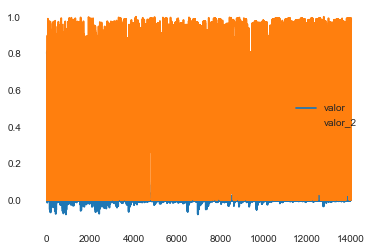

In [25]:
rowCorr.plot()

Text(0.5, 0.98, 'Smiling data and rolling window correlation')

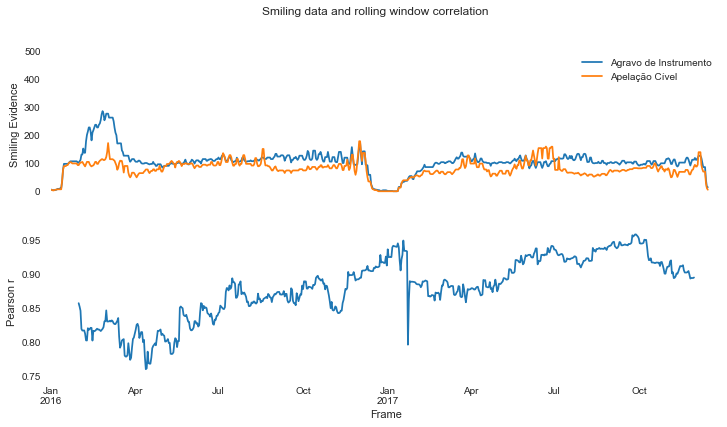

In [26]:
# Set window size to compute moving window synchrony.
r_window_size = 60
# Interpolate missing data.
df_interpolated = df[['Agravo de Instrumento','Apelação Cível']]['2016-01-01':].interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['Apelação Cível'].rolling(window=r_window_size, center=True).corr(df_interpolated['Agravo de Instrumento'])
f,ax=plt.subplots(2,1,figsize=(12,6),sharex=True)
df[['Agravo de Instrumento','Apelação Cível']].rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")

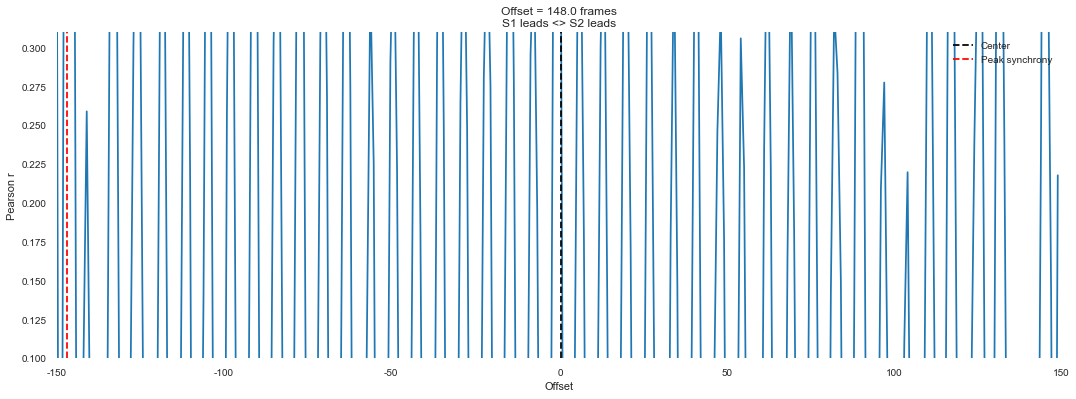

In [27]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))
    
dfR = df['2016-01-01':'2016-06-01'].copy()

d1 = dfR['Agravo de Instrumento']
d2 = dfR['Apelação Cível']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(18,6))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,301], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks([0, 50, 100, 151, 201, 251, 301])
ax.set_xticklabels([-150, -100, -50, 0, 50, 100, 150]);
plt.legend()